In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import cv2
from keras.models import load_model,Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense,Conv2D,Dropout,Flatten,AveragePooling2D,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from keras.backend import set_session,clear_session,get_session
import gc

# 輸出圖片
def show_images_labels_predictions(images,labels,predictions,start_id,num=10):
  plt.gcf().set_size_inches(12,14)
  if num>25: num=25
  for i in range(0,num):
    ax=plt.subplot(5,5,1+i) # 畫圖但用子圖呈現
    ax.imshow(images[start_id][:,:,[2,1,0]])
    if(len(predictions)>0):
      title='ai='+str(predictions[start_id])
      title+=('(o)' if predictions[start_id]==labels[start_id] else '(x)')
      title+='\nlabel='+str(labels[start_id])
    else:
      title='label='+str(labels[start_id])
    ax.set_title(title,fontsize=12)
    ax.set_xticks([]);ax.set_yticks([])
    start_id+=1
  plt.show()
    
# 重置keras
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))
np.random.seed(1)

# 可視化卷積後的圖片
def plot_feature_maps(feature_maps):
    num_features = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    display_grid = np.zeros((size, size * num_features))

    for i in range(num_features):
        feature_map = feature_maps[0, :, :, i]
        feature_map -= feature_map.mean()
        feature_map /= feature_map.std()
        feature_map *= 64
        feature_map += 128
        feature_map = np.clip(feature_map, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = feature_map

    scale = 20. / num_features
    plt.figure(figsize=(scale * num_features, scale))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# 讀取圖片,共七種類別
def data_preprocessing(cat_files, dog_files, wild_1, wild_2, wild_3, wild_4, wild_5):
    
    # 串列表達式並用cv2讀取並縮放圖片
    cat = [cv2.resize(cv2.imread(i), (128, 128)) for i in cat_files]
    dog = [cv2.resize(cv2.imread(i), (128,128)) for i in dog_files]
    fox = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_1]
    leopard = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_2]
    lion = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_3]
    tiger = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_4]
    wolf = [cv2.resize(cv2.imread(i), (128, 128)) for i in wild_5]
    
    cat = np.array(cat)
    dog = np.array(dog)
    fox = np.array(fox)
    leopard = np.array(leopard)
    lion = np.array(lion)
    tiger = np.array(tiger)
    wolf = np.array(wolf)

    # 定義一個陣列用來存放label,貓的label=0,狗的label=1,狐的label=2,豹的label=3,獅的label=4,虎的label=5,狼的label=6
    label = []
    for i in cat:
        label.append(0)
    for i in dog:
        label.append(1)
    for i in fox:
        label.append(2)
    for i in leopard:
        label.append(3)
    for i in lion:
        label.append(4)
    for i in tiger:
        label.append(5)
    for i in wolf:
        label.append(6)
        
    # 把前面分開讀取的圖片和為一個陣列,並做標準化處理
    feature = np.concatenate((cat, dog, fox, leopard, lion, tiger, wolf))
    feature = (feature.astype("float32") / 255)
    
    # 標籤做one-hot encoding
    label = np.array(label)
    print("貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6\n各類別樣本數:\n",pd.Series(label).value_counts())
    label = np_utils.to_categorical(label)

    return feature,label

<h1>處理資料

In [2]:
# 找到要讀取的檔案
cat = glob.glob("./train/cat/*.[jp][pn]g")
dog = glob.glob("./train/dog/*.[jp][pn]g")
fox = glob.glob("./train/fox/*.[jp][pn]g")
leopard = glob.glob("./train/leopard/*.[jp][pn]g")
lion = glob.glob("./train/lion/*.[jp][pn]g")
tiger = glob.glob("./train/tiger/*.[jp][pn]g")
wolf = glob.glob("./train/wolf/*.[jp][pn]g")

In [3]:
feature,label = data_preprocessing(cat, dog, fox, leopard, lion, tiger, wolf)

貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
各類別樣本數:
 3    6150
0    5603
1    5189
4    4868
5    4077
6    4074
2    3948
Name: count, dtype: int64


In [4]:
train_feature, test_feature, train_label, test_label = train_test_split(feature, label, test_size=0.1, random_state=40)
print(train_feature.shape, test_feature.shape, train_label.shape, test_label.shape)

(30518, 128, 128, 3) (3391, 128, 128, 3) (30518, 7) (3391, 7)


## CNN

8336


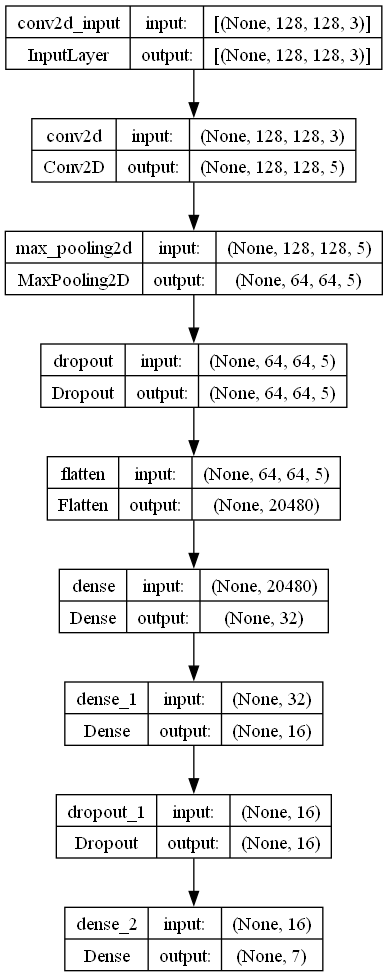

In [105]:
reset_keras()
model_CNN=Sequential()
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
#model_CNN.add(AveragePooling2D(pool_size=(2,2)))
model_CNN.add(Dropout(0.7))
model_CNN.add(Flatten())
model_CNN.add(Dense(units=32, activation='relu'))
model_CNN.add(Dense(units=16, activation='relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(units=7, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
plot_model(model_CNN,to_file='model.png',show_shapes=True)

In [106]:
from tensorflow.keras.models import Model
conv_layer_name = 'conv2d'
conv_intermediate = Model(inputs=model_CNN.input,outputs=model_CNN.get_layer(conv_layer_name).output)

In [107]:
pooling_layer_name = 'max_pooling2d'
#pooling_layer_name = 'average_pooling2d'
pooling_intermediate = Model(inputs=model_CNN.input,outputs=model_CNN.get_layer(pooling_layer_name).output)

In [108]:
np.random.seed(1)
con_img = conv_intermediate.predict(train_feature[:1])
pool_img = pooling_intermediate.predict(train_feature[:1])

1/1 [==============================] - 0s 26ms/step


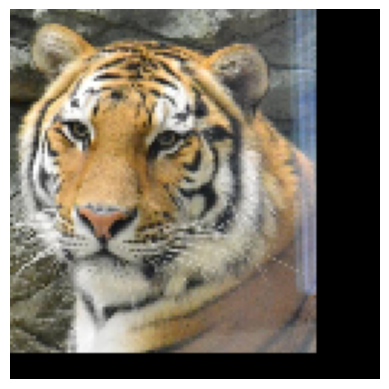

In [109]:
plt.imshow(train_feature[0])
plt.axis('off')
plt.show()

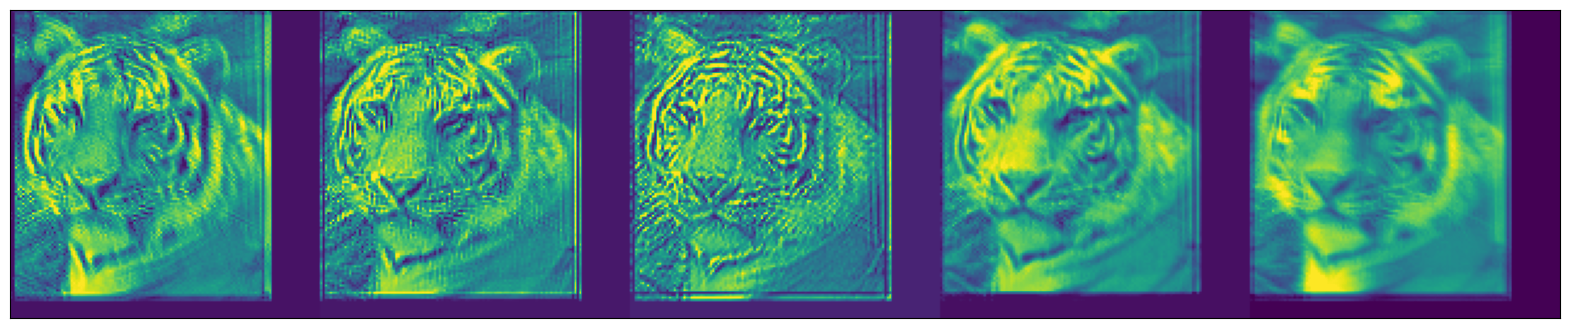

In [110]:
plot_feature_maps(con_img)

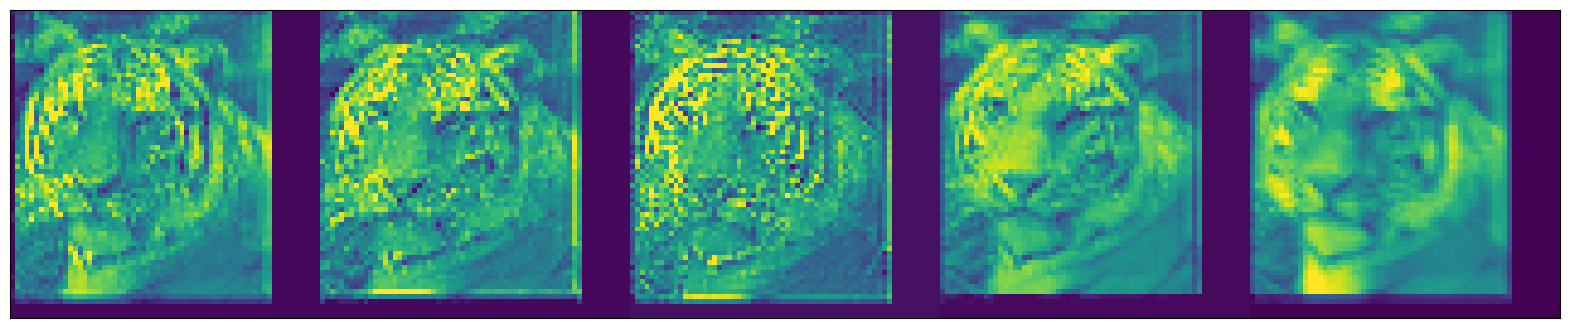

In [111]:
plot_feature_maps(pool_img)

In [47]:
reset_keras()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True,mode='min')

8338


In [112]:
reset_keras()
np.random.seed(1)
train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=30,batch_size=64,verbose=1)
#train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=30,batch_size=64,verbose=1,callbacks=early_stop)

8344
Epoch 1/30
430/430 [==============================] - 5s 11ms/step - loss: 1.7120 - accuracy: 0.3057 - val_loss: 1.3256 - val_accuracy: 0.5731
Epoch 2/30
430/430 [==============================] - 4s 10ms/step - loss: 1.1379 - accuracy: 0.5575 - val_loss: 0.7798 - val_accuracy: 0.7094
Epoch 3/30
430/430 [==============================] - 4s 10ms/step - loss: 0.9567 - accuracy: 0.6147 - val_loss: 0.7566 - val_accuracy: 0.6989
Epoch 4/30
430/430 [==============================] - 4s 10ms/step - loss: 0.8941 - accuracy: 0.6499 - val_loss: 0.6791 - val_accuracy: 0.7461
Epoch 5/30
430/430 [==============================] - 4s 10ms/step - loss: 0.8437 - accuracy: 0.6673 - val_loss: 0.6738 - val_accuracy: 0.7507
Epoch 6/30
430/430 [==============================] - 4s 10ms/step - loss: 0.8064 - accuracy: 0.6872 - val_loss: 0.6274 - val_accuracy: 0.7759
Epoch 7/30
430/430 [==============================] - 4s 10ms/step - loss: 0.7819 - accuracy: 0.7049 - val_loss: 0.6171 - val_accuracy: 0

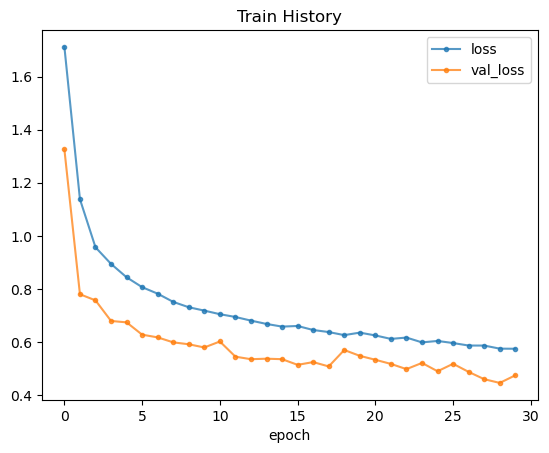

In [113]:
plt.title("Train History")
plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
plt.xlabel("epoch")
plt.legend(["loss","val_loss"])
plt.show()

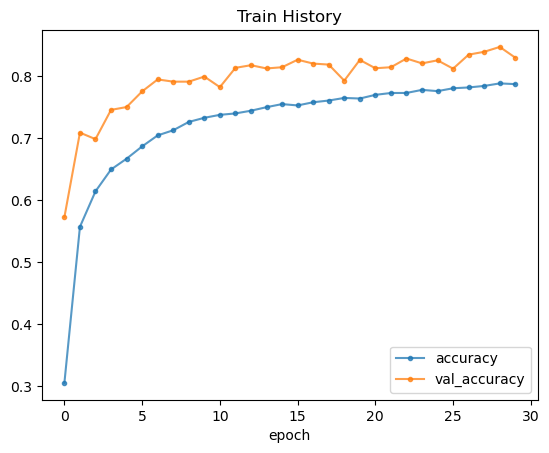

In [114]:
plt.title("Train History")
plt.plot(train_history.history['accuracy'],marker='.',alpha=0.75)
plt.plot(train_history.history['val_accuracy'],marker='.',alpha=0.75)
plt.xlabel("epoch")
plt.legend(["accuracy","val_accuracy"])
plt.show()

## 訓練指標

In [36]:
reset_keras()
pre=model_CNN.predict(test_feature)

15337
106/106 [==============================] - 0s 3ms/step


In [37]:
score=model_CNN.evaluate(test_feature,test_label)
print(score)

106/106 [==============================] - 0s 4ms/step - loss: 0.2793 - accuracy: 0.9210
[0.2792867124080658, 0.9209672808647156]


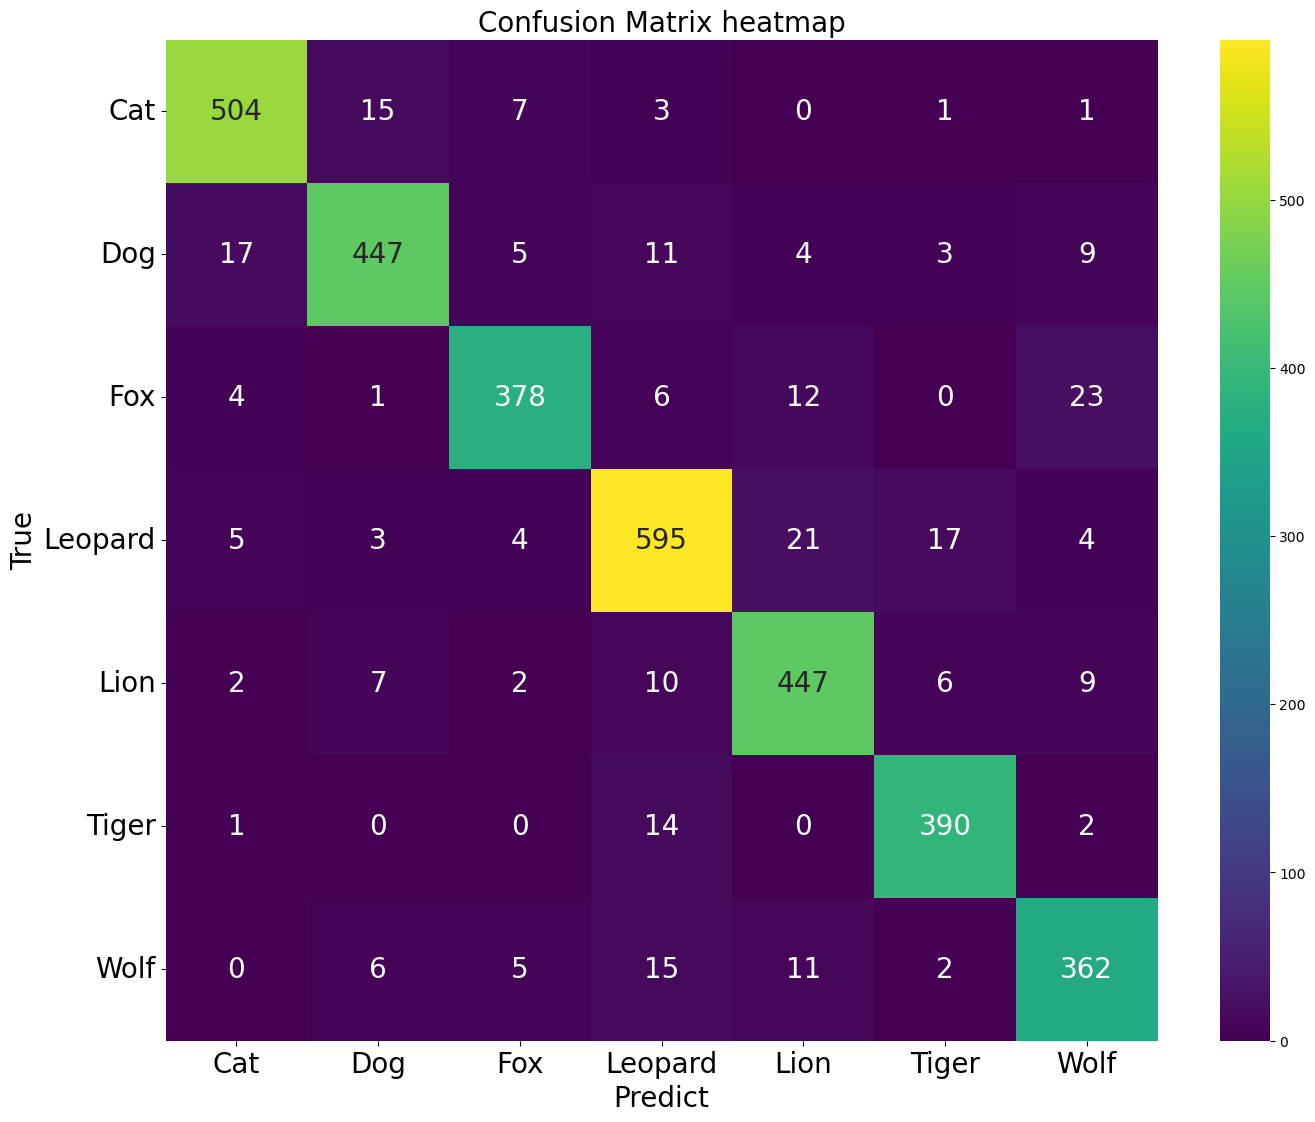

In [38]:
#貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
heatmap_label=["Cat","Dog","Fox","Leopard","Lion","Tiger","Wolf"]
from sklearn.metrics import confusion_matrix
import seaborn as sebrn
import matplotlib.pyplot as atlas
cm=confusion_matrix(np.argmax(test_label,axis=1),np.argmax(pre,axis=1))
plt.figure(figsize=(16, 13))
heatmap=sebrn.heatmap(cm,fmt='d',vmin=0,annot=True,cmap='viridis',annot_kws={"size": 20, "verticalalignment": "center", "horizontalalignment": "center"})
plt.ylabel("True",fontsize=20)
heatmap.set_xticklabels(heatmap_label, fontsize=20)
plt.xlabel("Predict",fontsize=20)
heatmap.set_yticklabels(heatmap_label, rotation=0, fontsize=20)
plt.title("Confusion Matrix heatmap",fontsize=20)
plt.show()

## 驗證集載入與驗證

In [115]:
val_cat = glob.glob("./val/cat/*.jpg")
val_dog = glob.glob("./val/dog/*.jpg")
val_fox = glob.glob("./val/fox/*.jpg")
val_leopard = glob.glob("./val/leopard/*.jpg")
val_lion = glob.glob("./val/lion/*.jpg")
val_tiger = glob.glob("./val/tiger/*.jpg")
val_wolf = glob.glob("./val/wolf/*.jpg")

In [116]:
val_feature, val_label = data_preprocessing(val_cat, val_dog, val_fox, val_leopard, val_lion, val_tiger, val_wolf)

貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
各類別樣本數:
 0    50
1    50
2    50
3    50
4    50
5    50
6    50
Name: count, dtype: int64


In [117]:
reset_keras()
val_pre=model_CNN.predict(val_feature)

10204
11/11 [==============================] - 0s 37ms/step


In [118]:
val_score=model_CNN.evaluate(val_feature,val_label)
print(val_score)

11/11 [==============================] - 0s 4ms/step - loss: 0.4817 - accuracy: 0.8314
[0.4816892743110657, 0.831428587436676]


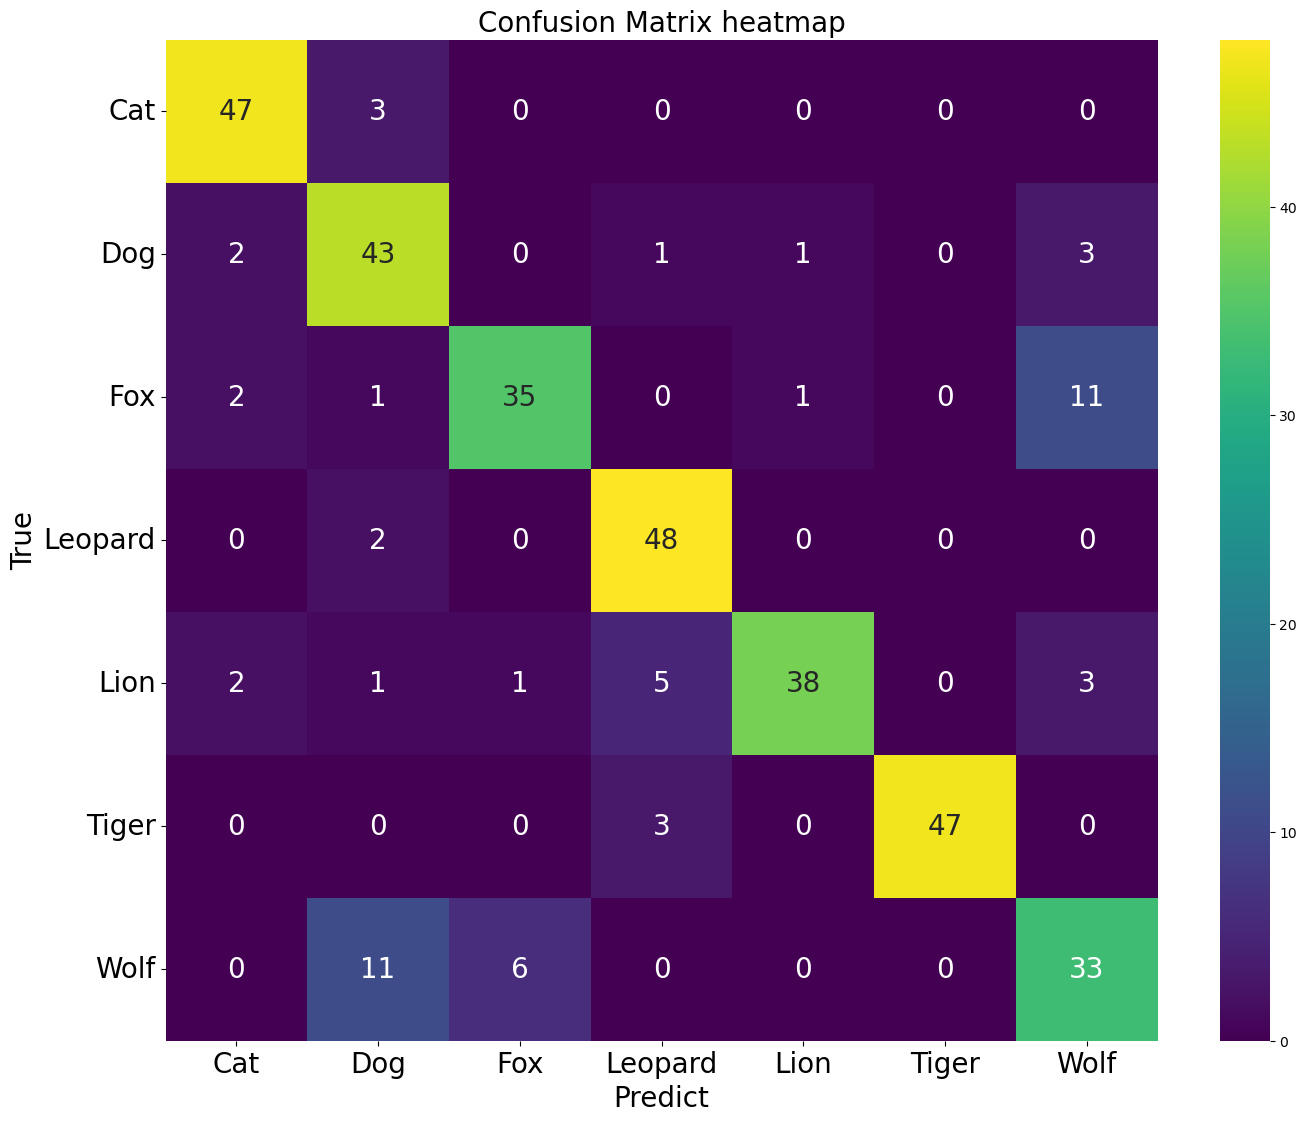

貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
訓練集各類別樣本數:
 3    5501
0    5072
1    4693
4    4385
6    3673
5    3670
2    3524
Name: count, dtype: int64


In [123]:
#貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6
heatmap_label=["Cat","Dog","Fox","Leopard","Lion","Tiger","Wolf"]
from sklearn.metrics import confusion_matrix
import seaborn as sebrn
import matplotlib.pyplot as atlas
cm=confusion_matrix(np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1))
plt.figure(figsize=(16, 13))
heatmap=sebrn.heatmap(cm,fmt='d',vmin=0,annot=True,cmap='viridis',annot_kws={"size": 20, "verticalalignment": "center", "horizontalalignment": "center"})
plt.ylabel("True",fontsize=20)
heatmap.set_xticklabels(heatmap_label, fontsize=20)
plt.xlabel("Predict",fontsize=20)
heatmap.set_yticklabels(heatmap_label, rotation=0, fontsize=20)
plt.title("Confusion Matrix heatmap",fontsize=20)
plt.show()
print("貓=0,狗=1,狐=2,豹=3,獅=4,虎=5,狼=6\n訓練集各類別樣本數:\n",pd.Series(np.argmax(train_label, axis=1)).value_counts())

## 實驗1-卷積層數選擇

3277
Epoch 1/20
171/171 [==============================] - 2s 11ms/step - loss: 0.7520 - accuracy: 0.6502 - val_loss: 0.5322 - val_accuracy: 0.8000
Epoch 2/20
171/171 [==============================] - 2s 10ms/step - loss: 0.3980 - accuracy: 0.8460 - val_loss: 0.3700 - val_accuracy: 0.8510
Epoch 3/20
171/171 [==============================] - 2s 10ms/step - loss: 0.3085 - accuracy: 0.8872 - val_loss: 0.3496 - val_accuracy: 0.8675
Epoch 4/20
171/171 [==============================] - 2s 10ms/step - loss: 0.2430 - accuracy: 0.9130 - val_loss: 0.3024 - val_accuracy: 0.8840
Epoch 5/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1958 - accuracy: 0.9302 - val_loss: 0.3088 - val_accuracy: 0.8872
Epoch 6/20
171/171 [==============================] - 2s 11ms/step - loss: 0.1569 - accuracy: 0.9461 - val_loss: 0.2702 - val_accuracy: 0.9029
Epoch 7/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1286 - accuracy: 0.9570 - val_loss: 0.3023 - val_accuracy: 0

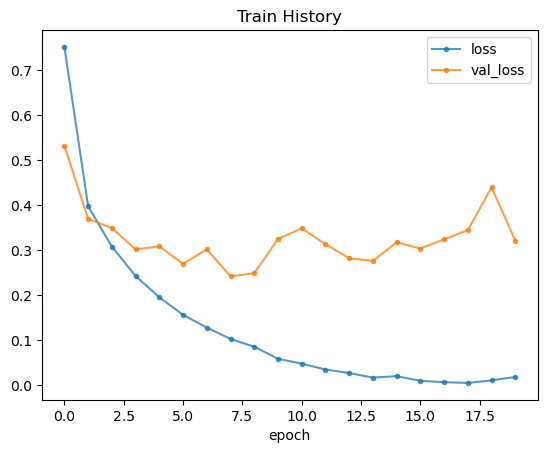

43/43 [==============================] - 0s 4ms/step - loss: 0.3722 - accuracy: 0.9037
[[0.3721960186958313, 0.9037036895751953]]
7955
Epoch 1/20
171/171 [==============================] - 2s 11ms/step - loss: 0.6893 - accuracy: 0.7151 - val_loss: 0.3668 - val_accuracy: 0.8716
Epoch 2/20
171/171 [==============================] - 2s 10ms/step - loss: 0.3198 - accuracy: 0.8833 - val_loss: 0.3358 - val_accuracy: 0.8741
Epoch 3/20
171/171 [==============================] - 2s 10ms/step - loss: 0.2409 - accuracy: 0.9128 - val_loss: 0.2586 - val_accuracy: 0.9078
Epoch 4/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1810 - accuracy: 0.9339 - val_loss: 0.2932 - val_accuracy: 0.8938
Epoch 5/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1371 - accuracy: 0.9516 - val_loss: 0.2481 - val_accuracy: 0.9160
Epoch 6/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1054 - accuracy: 0.9659 - val_loss: 0.2466 - val_accuracy: 0.9226
Epoch 7

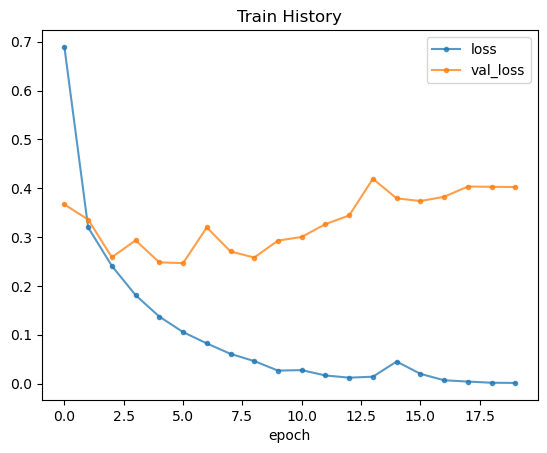

43/43 [==============================] - 0s 4ms/step - loss: 0.3986 - accuracy: 0.9156
[[0.3721960186958313, 0.9037036895751953], [0.3986002504825592, 0.9155555367469788]]
7096
Epoch 1/20
171/171 [==============================] - 2s 11ms/step - loss: 0.7126 - accuracy: 0.7114 - val_loss: 0.4141 - val_accuracy: 0.8436
Epoch 2/20
171/171 [==============================] - 2s 10ms/step - loss: 0.3545 - accuracy: 0.8681 - val_loss: 0.3261 - val_accuracy: 0.8774
Epoch 3/20
171/171 [==============================] - 2s 10ms/step - loss: 0.2601 - accuracy: 0.9046 - val_loss: 0.3254 - val_accuracy: 0.8765
Epoch 4/20
171/171 [==============================] - 2s 10ms/step - loss: 0.2128 - accuracy: 0.9222 - val_loss: 0.2877 - val_accuracy: 0.8922
Epoch 5/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1670 - accuracy: 0.9418 - val_loss: 0.2656 - val_accuracy: 0.9004
Epoch 6/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1373 - accuracy: 0.9513 - val_l

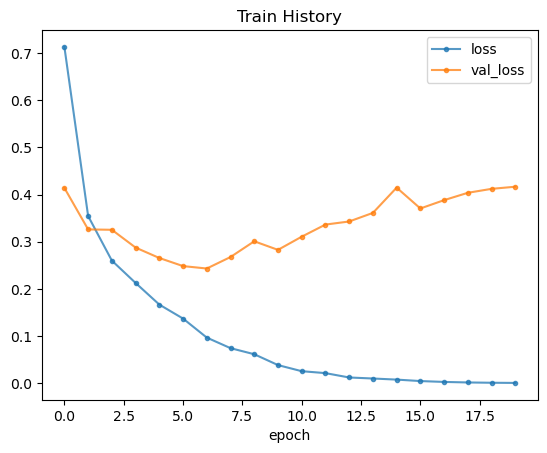

43/43 [==============================] - 0s 4ms/step - loss: 0.4966 - accuracy: 0.9015
[[0.3721960186958313, 0.9037036895751953], [0.3986002504825592, 0.9155555367469788], [0.496555358171463, 0.9014815092086792]]
7096
Epoch 1/20
171/171 [==============================] - 2s 11ms/step - loss: 0.9972 - accuracy: 0.5052 - val_loss: 0.6706 - val_accuracy: 0.7202
Epoch 2/20
171/171 [==============================] - 2s 13ms/step - loss: 0.4508 - accuracy: 0.8279 - val_loss: 0.3478 - val_accuracy: 0.8790
Epoch 3/20
171/171 [==============================] - 2s 11ms/step - loss: 0.2863 - accuracy: 0.8966 - val_loss: 0.2689 - val_accuracy: 0.9053
Epoch 4/20
171/171 [==============================] - 2s 11ms/step - loss: 0.2163 - accuracy: 0.9208 - val_loss: 0.2273 - val_accuracy: 0.9226
Epoch 5/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1684 - accuracy: 0.9405 - val_loss: 0.2353 - val_accuracy: 0.9185
Epoch 6/20
171/171 [==============================] - 2s 10ms/step 

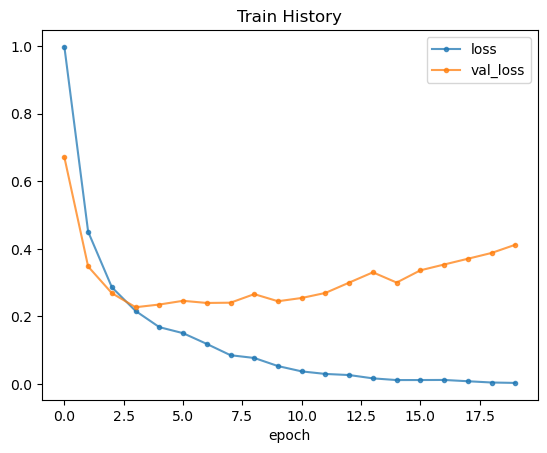

43/43 [==============================] - 0s 4ms/step - loss: 0.4762 - accuracy: 0.8985
[[0.3721960186958313, 0.9037036895751953], [0.3986002504825592, 0.9155555367469788], [0.496555358171463, 0.9014815092086792], [0.47615745663642883, 0.8985185027122498]]
6895
Epoch 1/20
171/171 [==============================] - 2s 11ms/step - loss: 0.6436 - accuracy: 0.7260 - val_loss: 0.3618 - val_accuracy: 0.8708
Epoch 2/20
171/171 [==============================] - 2s 10ms/step - loss: 0.3004 - accuracy: 0.8895 - val_loss: 0.3926 - val_accuracy: 0.8436
Epoch 3/20
171/171 [==============================] - 2s 10ms/step - loss: 0.2120 - accuracy: 0.9245 - val_loss: 0.2510 - val_accuracy: 0.9045
Epoch 4/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1495 - accuracy: 0.9481 - val_loss: 0.2637 - val_accuracy: 0.9021
Epoch 5/20
171/171 [==============================] - 2s 10ms/step - loss: 0.1131 - accuracy: 0.9630 - val_loss: 0.2366 - val_accuracy: 0.9053
Epoch 6/20
171/171 [====

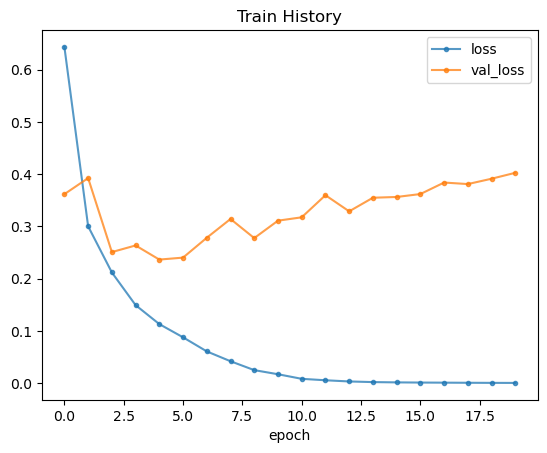

43/43 [==============================] - 0s 4ms/step - loss: 0.3959 - accuracy: 0.9126
[[0.3721960186958313, 0.9037036895751953], [0.3986002504825592, 0.9155555367469788], [0.496555358171463, 0.9014815092086792], [0.47615745663642883, 0.8985185027122498], [0.39593830704689026, 0.9125925898551941]]


In [15]:
score=[]
for i in range(5):
    np.random.seed(i)
    reset_keras()
    model_CNN=Sequential()
    model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(units=32, activation='relu'))
    model_CNN.add(Dense(units=16, activation='relu'))
    model_CNN.add(Dense(units=3, activation='softmax'))
    model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    if i == 1:
        plot_model(model_CNN,show_shapes=True)
    train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=20,batch_size=64,verbose=1)
    plt.title("Train History")
    plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
    plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
    plt.xlabel("epoch")
    plt.legend(["loss","val_loss"])
    plt.show()
    score.append(model_CNN.evaluate(test_feature,test_label))
print(score)

7000
Epoch 1/20
171/171 [==============================] - 3s 15ms/step - loss: 0.5726 - accuracy: 0.7641 - val_loss: 0.3267 - val_accuracy: 0.8741
Epoch 2/20
171/171 [==============================] - 2s 12ms/step - loss: 0.3008 - accuracy: 0.8901 - val_loss: 0.2923 - val_accuracy: 0.8881
Epoch 3/20
171/171 [==============================] - 2s 12ms/step - loss: 0.2592 - accuracy: 0.9067 - val_loss: 0.2535 - val_accuracy: 0.9037
Epoch 4/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2086 - accuracy: 0.9243 - val_loss: 0.2229 - val_accuracy: 0.9185
Epoch 5/20
171/171 [==============================] - 2s 14ms/step - loss: 0.1811 - accuracy: 0.9352 - val_loss: 0.2472 - val_accuracy: 0.9128
Epoch 6/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1711 - accuracy: 0.9364 - val_loss: 0.2143 - val_accuracy: 0.9276
Epoch 7/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1170 - accuracy: 0.9571 - val_loss: 0.1804 - val_accuracy: 0

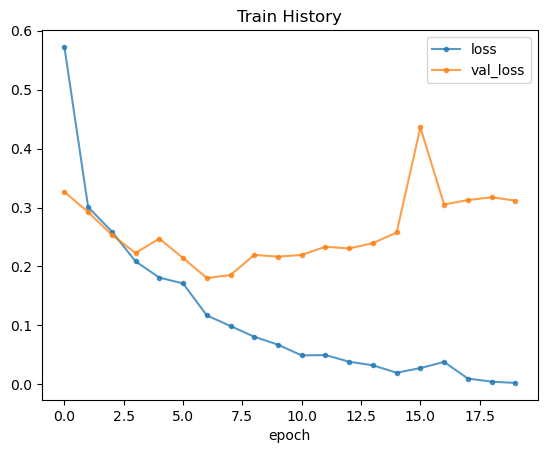

43/43 [==============================] - 0s 5ms/step - loss: 0.3150 - accuracy: 0.9363
7777
Epoch 1/20
171/171 [==============================] - 3s 14ms/step - loss: 0.6207 - accuracy: 0.7343 - val_loss: 0.3559 - val_accuracy: 0.8650
Epoch 2/20
171/171 [==============================] - 2s 12ms/step - loss: 0.3173 - accuracy: 0.8834 - val_loss: 0.2386 - val_accuracy: 0.9119
Epoch 3/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2376 - accuracy: 0.9151 - val_loss: 0.2388 - val_accuracy: 0.9053
Epoch 4/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1927 - accuracy: 0.9305 - val_loss: 0.1914 - val_accuracy: 0.9292
Epoch 5/20
171/171 [==============================] - 2s 12ms/step - loss: 0.1522 - accuracy: 0.9473 - val_loss: 0.1874 - val_accuracy: 0.9342
Epoch 6/20
171/171 [==============================] - 2s 12ms/step - loss: 0.1271 - accuracy: 0.9549 - val_loss: 0.1701 - val_accuracy: 0.9440
Epoch 7/20
171/171 [==============================

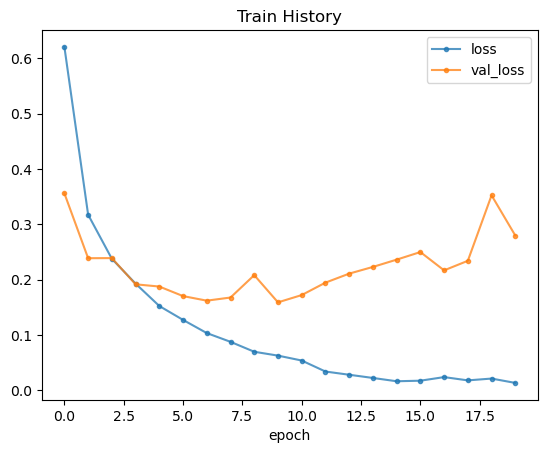

43/43 [==============================] - 0s 4ms/step - loss: 0.2851 - accuracy: 0.9385
7866
Epoch 1/20
171/171 [==============================] - 3s 14ms/step - loss: 0.6621 - accuracy: 0.7090 - val_loss: 0.3981 - val_accuracy: 0.8494
Epoch 2/20
171/171 [==============================] - 2s 12ms/step - loss: 0.3588 - accuracy: 0.8624 - val_loss: 0.3165 - val_accuracy: 0.8798
Epoch 3/20
171/171 [==============================] - 2s 13ms/step - loss: 0.3061 - accuracy: 0.8875 - val_loss: 0.2790 - val_accuracy: 0.9004
Epoch 4/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2683 - accuracy: 0.9005 - val_loss: 0.2942 - val_accuracy: 0.8872
Epoch 5/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2186 - accuracy: 0.9202 - val_loss: 0.2637 - val_accuracy: 0.9004
Epoch 6/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1860 - accuracy: 0.9331 - val_loss: 0.2384 - val_accuracy: 0.9144
Epoch 7/20
171/171 [==============================

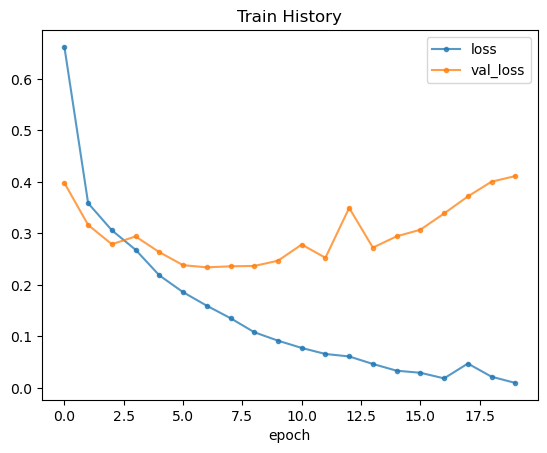

43/43 [==============================] - 0s 6ms/step - loss: 0.3137 - accuracy: 0.9296
7876
Epoch 1/20
171/171 [==============================] - 3s 16ms/step - loss: 0.6434 - accuracy: 0.7210 - val_loss: 0.4168 - val_accuracy: 0.8346
Epoch 2/20
171/171 [==============================] - 3s 15ms/step - loss: 0.3678 - accuracy: 0.8594 - val_loss: 0.3836 - val_accuracy: 0.8593
Epoch 3/20
171/171 [==============================] - 2s 15ms/step - loss: 0.3019 - accuracy: 0.8882 - val_loss: 0.2602 - val_accuracy: 0.9012
Epoch 4/20
171/171 [==============================] - 2s 14ms/step - loss: 0.2327 - accuracy: 0.9141 - val_loss: 0.2232 - val_accuracy: 0.9144
Epoch 5/20
171/171 [==============================] - 2s 14ms/step - loss: 0.1904 - accuracy: 0.9286 - val_loss: 0.2374 - val_accuracy: 0.9160
Epoch 6/20
171/171 [==============================] - 2s 15ms/step - loss: 0.1553 - accuracy: 0.9447 - val_loss: 0.2820 - val_accuracy: 0.9004
Epoch 7/20
171/171 [==============================

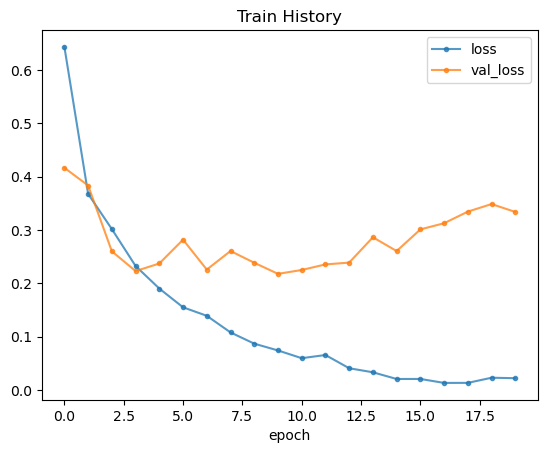

43/43 [==============================] - 0s 4ms/step - loss: 0.3161 - accuracy: 0.9348
7866
Epoch 1/20
171/171 [==============================] - 3s 13ms/step - loss: 0.5459 - accuracy: 0.7719 - val_loss: 0.2744 - val_accuracy: 0.9029
Epoch 2/20
171/171 [==============================] - 2s 12ms/step - loss: 0.2524 - accuracy: 0.9097 - val_loss: 0.2101 - val_accuracy: 0.9350
Epoch 3/20
171/171 [==============================] - 2s 12ms/step - loss: 0.1969 - accuracy: 0.9290 - val_loss: 0.2095 - val_accuracy: 0.9317
Epoch 4/20
171/171 [==============================] - 2s 12ms/step - loss: 0.1440 - accuracy: 0.9475 - val_loss: 0.1860 - val_accuracy: 0.9399
Epoch 5/20
171/171 [==============================] - 2s 12ms/step - loss: 0.1226 - accuracy: 0.9574 - val_loss: 0.1791 - val_accuracy: 0.9473
Epoch 6/20
171/171 [==============================] - 2s 12ms/step - loss: 0.0875 - accuracy: 0.9686 - val_loss: 0.1615 - val_accuracy: 0.9465
Epoch 7/20
171/171 [==============================

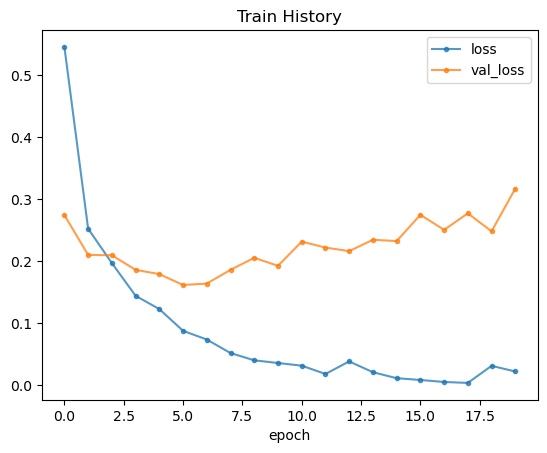

43/43 [==============================] - 0s 4ms/step - loss: 0.3969 - accuracy: 0.9156
[[0.3150255084037781, 0.936296284198761], [0.28510862588882446, 0.9385185241699219], [0.31366467475891113, 0.9296296238899231], [0.3160771131515503, 0.9348148107528687], [0.39694082736968994, 0.9155555367469788]]


In [16]:
score=[]
for i in range(5):
    np.random.seed(i)
    reset_keras()
    model_CNN=Sequential()
    model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(units=32, activation='relu'))
    model_CNN.add(Dense(units=16, activation='relu'))
    model_CNN.add(Dense(units=3, activation='softmax'))
    model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    if i == 1:
        plot_model(model_CNN,show_shapes=True)
    train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=20,batch_size=64,verbose=1)
    plt.title("Train History")
    plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
    plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
    plt.xlabel("epoch")
    plt.legend(["loss","val_loss"])
    plt.show()
    score.append(model_CNN.evaluate(test_feature,test_label))
print(score)

7768
Epoch 1/20
171/171 [==============================] - 3s 15ms/step - loss: 0.6839 - accuracy: 0.6945 - val_loss: 0.4441 - val_accuracy: 0.8263
Epoch 2/20
171/171 [==============================] - 2s 13ms/step - loss: 0.3336 - accuracy: 0.8743 - val_loss: 0.3054 - val_accuracy: 0.8955
Epoch 3/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2567 - accuracy: 0.9041 - val_loss: 0.2830 - val_accuracy: 0.9004
Epoch 4/20
171/171 [==============================] - 2s 14ms/step - loss: 0.1995 - accuracy: 0.9282 - val_loss: 0.2328 - val_accuracy: 0.9259
Epoch 5/20
171/171 [==============================] - 2s 14ms/step - loss: 0.1839 - accuracy: 0.9310 - val_loss: 0.2030 - val_accuracy: 0.9358
Epoch 6/20
171/171 [==============================] - 2s 14ms/step - loss: 0.1541 - accuracy: 0.9424 - val_loss: 0.2137 - val_accuracy: 0.9276
Epoch 7/20
171/171 [==============================] - 2s 14ms/step - loss: 0.1381 - accuracy: 0.9503 - val_loss: 0.1992 - val_accuracy: 0

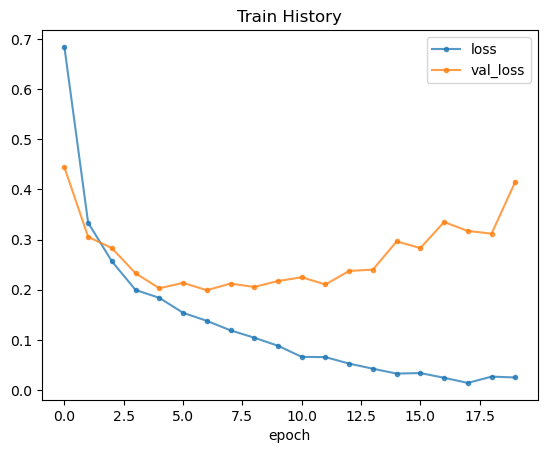

43/43 [==============================] - 0s 4ms/step - loss: 0.3955 - accuracy: 0.9326
8012
Epoch 1/20
171/171 [==============================] - 3s 14ms/step - loss: 0.6140 - accuracy: 0.7362 - val_loss: 0.3487 - val_accuracy: 0.8650
Epoch 2/20
171/171 [==============================] - 2s 14ms/step - loss: 0.3283 - accuracy: 0.8781 - val_loss: 0.2843 - val_accuracy: 0.8971
Epoch 3/20
171/171 [==============================] - 2s 14ms/step - loss: 0.2615 - accuracy: 0.9041 - val_loss: 0.2260 - val_accuracy: 0.9177
Epoch 4/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2273 - accuracy: 0.9186 - val_loss: 0.2085 - val_accuracy: 0.9267
Epoch 5/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1961 - accuracy: 0.9244 - val_loss: 0.2259 - val_accuracy: 0.9111
Epoch 6/20
171/171 [==============================] - 2s 14ms/step - loss: 0.1728 - accuracy: 0.9388 - val_loss: 0.2352 - val_accuracy: 0.9185
Epoch 7/20
171/171 [==============================

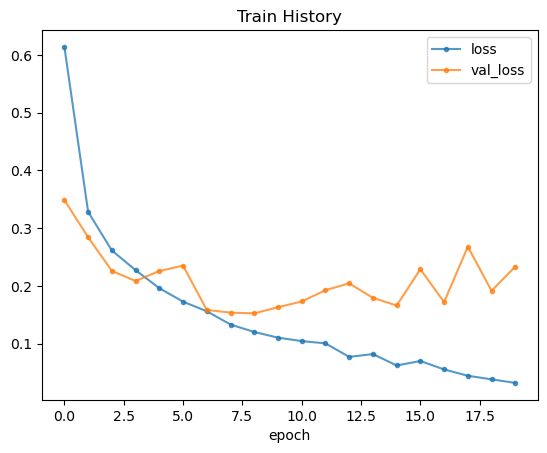

43/43 [==============================] - 0s 6ms/step - loss: 0.2368 - accuracy: 0.9415
4801
Epoch 1/20
171/171 [==============================] - 3s 15ms/step - loss: 0.7393 - accuracy: 0.6615 - val_loss: 0.4569 - val_accuracy: 0.8313
Epoch 2/20
171/171 [==============================] - 2s 13ms/step - loss: 0.4154 - accuracy: 0.8421 - val_loss: 0.4164 - val_accuracy: 0.8305
Epoch 3/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2949 - accuracy: 0.8916 - val_loss: 0.2618 - val_accuracy: 0.9095
Epoch 4/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2270 - accuracy: 0.9153 - val_loss: 0.2563 - val_accuracy: 0.9103
Epoch 5/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1982 - accuracy: 0.9256 - val_loss: 0.2488 - val_accuracy: 0.9202
Epoch 6/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1672 - accuracy: 0.9376 - val_loss: 0.2125 - val_accuracy: 0.9325
Epoch 7/20
171/171 [==============================

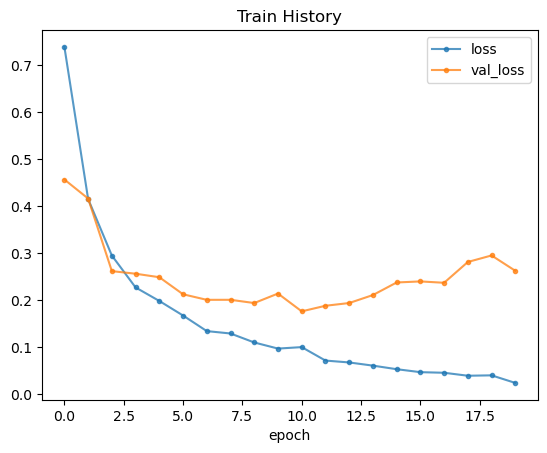

43/43 [==============================] - 0s 4ms/step - loss: 0.2261 - accuracy: 0.9444
8202
Epoch 1/20
171/171 [==============================] - 3s 14ms/step - loss: 0.6844 - accuracy: 0.6938 - val_loss: 0.4328 - val_accuracy: 0.8296
Epoch 2/20
171/171 [==============================] - 2s 14ms/step - loss: 0.3689 - accuracy: 0.8615 - val_loss: 0.2993 - val_accuracy: 0.8905
Epoch 3/20
171/171 [==============================] - 2s 14ms/step - loss: 0.2744 - accuracy: 0.8977 - val_loss: 0.2537 - val_accuracy: 0.9037
Epoch 4/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2349 - accuracy: 0.9096 - val_loss: 0.2048 - val_accuracy: 0.9276
Epoch 5/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2019 - accuracy: 0.9271 - val_loss: 0.2263 - val_accuracy: 0.9152
Epoch 6/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1681 - accuracy: 0.9376 - val_loss: 0.1843 - val_accuracy: 0.9399
Epoch 7/20
171/171 [==============================

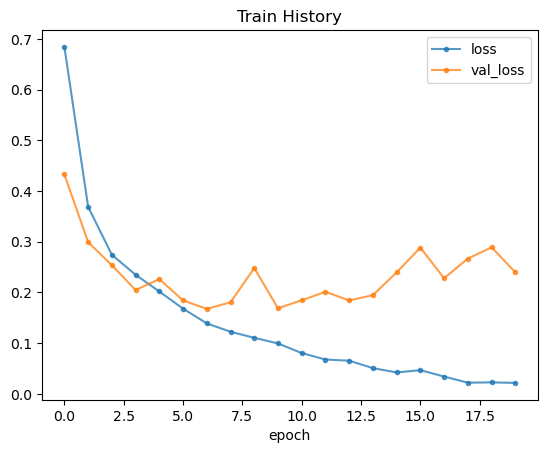

43/43 [==============================] - 0s 5ms/step - loss: 0.2860 - accuracy: 0.9304
8212
Epoch 1/20
171/171 [==============================] - 3s 15ms/step - loss: 0.7206 - accuracy: 0.6628 - val_loss: 0.4026 - val_accuracy: 0.8576
Epoch 2/20
171/171 [==============================] - 2s 13ms/step - loss: 0.3525 - accuracy: 0.8672 - val_loss: 0.2827 - val_accuracy: 0.8971
Epoch 3/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2638 - accuracy: 0.9029 - val_loss: 0.2389 - val_accuracy: 0.9062
Epoch 4/20
171/171 [==============================] - 2s 13ms/step - loss: 0.2129 - accuracy: 0.9193 - val_loss: 0.1992 - val_accuracy: 0.9202
Epoch 5/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1781 - accuracy: 0.9348 - val_loss: 0.1885 - val_accuracy: 0.9276
Epoch 6/20
171/171 [==============================] - 2s 13ms/step - loss: 0.1505 - accuracy: 0.9435 - val_loss: 0.1618 - val_accuracy: 0.9416
Epoch 7/20
171/171 [==============================

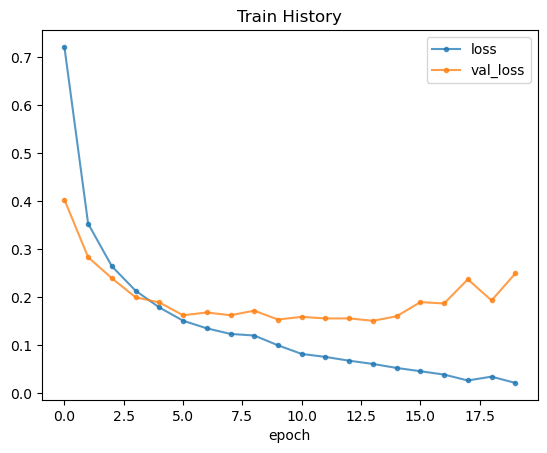

43/43 [==============================] - 0s 5ms/step - loss: 0.2219 - accuracy: 0.9437
[[0.3955315351486206, 0.9325925707817078], [0.23684455454349518, 0.9414814710617065], [0.22610437870025635, 0.9444444179534912], [0.28597256541252136, 0.9303703904151917], [0.22188237309455872, 0.9437037110328674]]


In [17]:
score=[]
for i in range(5):
    np.random.seed(i)
    reset_keras()
    model_CNN=Sequential()
    model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
    model_CNN.add(MaxPooling2D(pool_size=(2,2)))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(units=32, activation='relu'))
    model_CNN.add(Dense(units=16, activation='relu'))
    model_CNN.add(Dense(units=3, activation='softmax'))
    model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    if i == 1:
        plot_model(model_CNN,show_shapes=True)
    train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=20,batch_size=64,verbose=1)
    plt.title("Train History")
    plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
    plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
    plt.xlabel("epoch")
    plt.legend(["loss","val_loss"])
    plt.show()
    score.append(model_CNN.evaluate(test_feature,test_label))
print(score)

## 實驗2-加入拋棄

-------------------------------
當前拋棄比例0.200000
3260
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.7149 - accuracy: 0.6645 - val_loss: 0.4634 - val_accuracy: 0.8155
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.4183 - accuracy: 0.8322 - val_loss: 0.3275 - val_accuracy: 0.8785
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2978 - accuracy: 0.8857 - val_loss: 0.3270 - val_accuracy: 0.8717
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2296 - accuracy: 0.9131 - val_loss: 0.2619 - val_accuracy: 0.9021
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2029 - accuracy: 0.9221 - val_loss: 0.2023 - val_accuracy: 0.9271
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1750 - accuracy: 0.9365 - val_loss: 0.1909 - val_accuracy: 0.9256
Epoch 7/30
186/186 [==============================] - 3s 14ms/step - loss: 0.1607 - accura

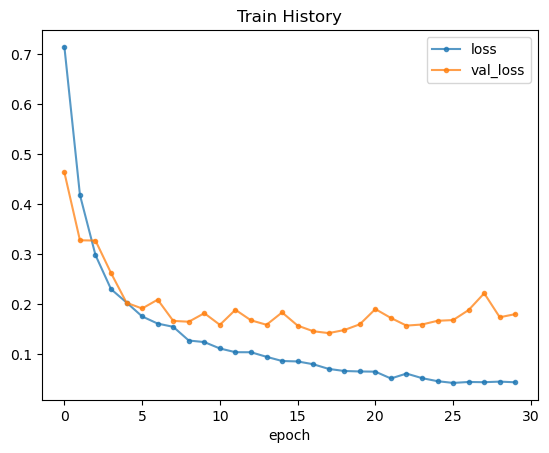

46/46 [==============================] - 0s 4ms/step - loss: 0.1679 - accuracy: 0.9481
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7299 - accuracy: 0.6769 - val_loss: 0.4208 - val_accuracy: 0.8307
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3789 - accuracy: 0.8548 - val_loss: 0.2764 - val_accuracy: 0.8945
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2917 - accuracy: 0.8922 - val_loss: 0.3563 - val_accuracy: 0.8588
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2668 - accuracy: 0.9025 - val_loss: 0.2117 - val_accuracy: 0.9203
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2268 - accuracy: 0.9203 - val_loss: 0.2127 - val_accuracy: 0.9203
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2039 - accuracy: 0.9261 - val_loss: 0.1860 - val_accuracy: 0.9294
Epoch 7/30
186/186 [==============================

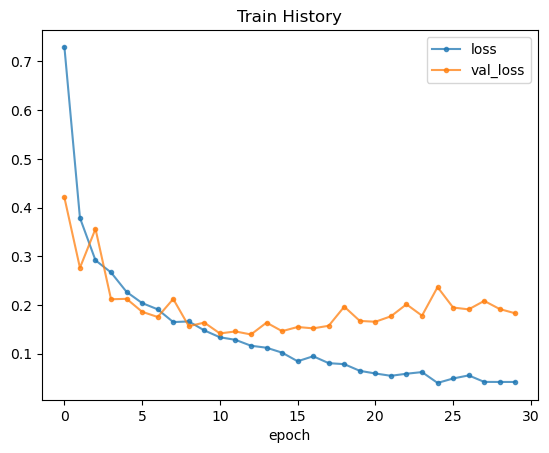

46/46 [==============================] - 0s 4ms/step - loss: 0.1847 - accuracy: 0.9440
8701
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6281 - accuracy: 0.7300 - val_loss: 0.4062 - val_accuracy: 0.8428
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3543 - accuracy: 0.8660 - val_loss: 0.3187 - val_accuracy: 0.8785
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2655 - accuracy: 0.9015 - val_loss: 0.2511 - val_accuracy: 0.9089
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2143 - accuracy: 0.9196 - val_loss: 0.1942 - val_accuracy: 0.9362
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1938 - accuracy: 0.9277 - val_loss: 0.1721 - val_accuracy: 0.9355
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1665 - accuracy: 0.9364 - val_loss: 0.1659 - val_accuracy: 0.9400
Epoch 7/30
186/186 [==============================

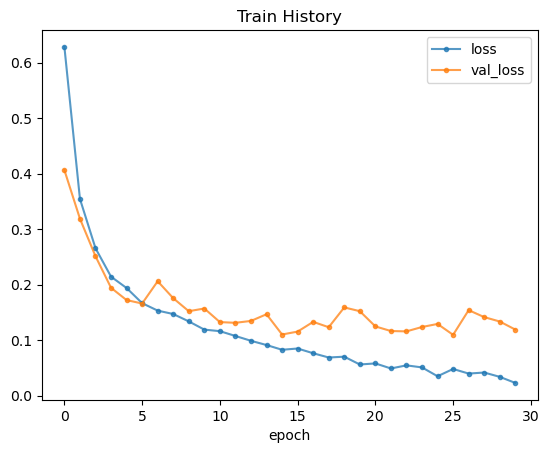

46/46 [==============================] - 0s 4ms/step - loss: 0.1288 - accuracy: 0.9617
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6293 - accuracy: 0.7260 - val_loss: 0.3615 - val_accuracy: 0.8656
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3267 - accuracy: 0.8759 - val_loss: 0.2947 - val_accuracy: 0.8815
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2535 - accuracy: 0.9058 - val_loss: 0.2654 - val_accuracy: 0.9058
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2237 - accuracy: 0.9174 - val_loss: 0.2139 - val_accuracy: 0.9218
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1955 - accuracy: 0.9294 - val_loss: 0.2073 - val_accuracy: 0.9248
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1694 - accuracy: 0.9378 - val_loss: 0.2257 - val_accuracy: 0.9180
Epoch 7/30
186/186 [==============================

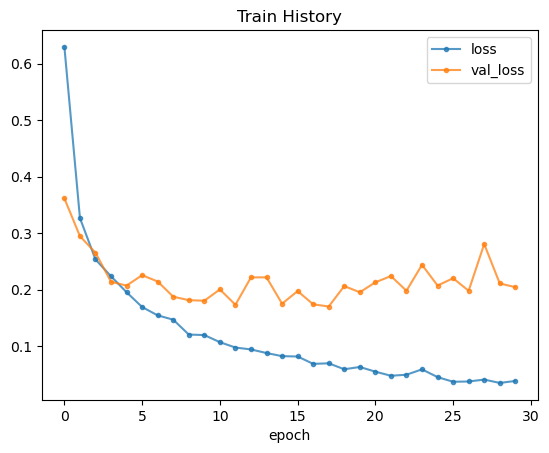

46/46 [==============================] - 0s 4ms/step - loss: 0.1856 - accuracy: 0.9481
7916
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7130 - accuracy: 0.6738 - val_loss: 0.4230 - val_accuracy: 0.8497
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3558 - accuracy: 0.8686 - val_loss: 0.2995 - val_accuracy: 0.8785
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2792 - accuracy: 0.8962 - val_loss: 0.2365 - val_accuracy: 0.9066
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2375 - accuracy: 0.9122 - val_loss: 0.2347 - val_accuracy: 0.9112
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2091 - accuracy: 0.9246 - val_loss: 0.2001 - val_accuracy: 0.9286
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.1881 - accuracy: 0.9321 - val_loss: 0.1765 - val_accuracy: 0.9355
Epoch 7/30
186/186 [==============================

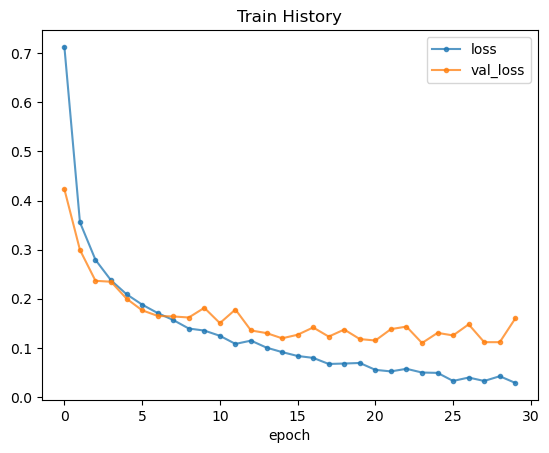

46/46 [==============================] - 0s 4ms/step - loss: 0.1416 - accuracy: 0.9617
-------------------------------
當前拋棄比例0.300000
8094
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6967 - accuracy: 0.6971 - val_loss: 0.4463 - val_accuracy: 0.8368
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3740 - accuracy: 0.8540 - val_loss: 0.3328 - val_accuracy: 0.8664
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2724 - accuracy: 0.9007 - val_loss: 0.2266 - val_accuracy: 0.9226
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2366 - accuracy: 0.9105 - val_loss: 0.2151 - val_accuracy: 0.9172
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2114 - accuracy: 0.9204 - val_loss: 0.2000 - val_accuracy: 0.9241
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1944 - accuracy: 0.9270 - val_loss: 0.1766 - val_accuracy: 0.9339
Epo

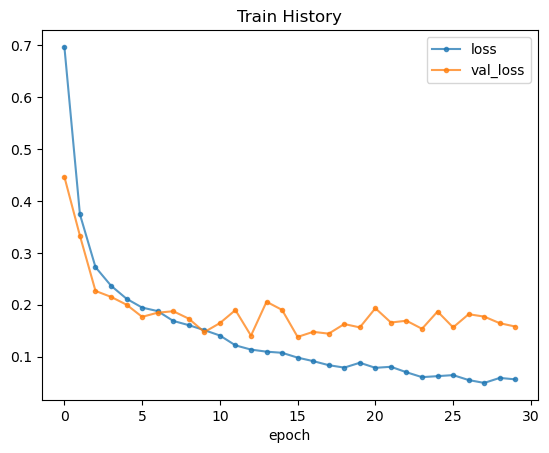

46/46 [==============================] - 0s 4ms/step - loss: 0.1226 - accuracy: 0.9583
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7535 - accuracy: 0.6581 - val_loss: 0.5830 - val_accuracy: 0.7350
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.4137 - accuracy: 0.8415 - val_loss: 0.3164 - val_accuracy: 0.8793
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3380 - accuracy: 0.8740 - val_loss: 0.2660 - val_accuracy: 0.9013
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2719 - accuracy: 0.8990 - val_loss: 0.2567 - val_accuracy: 0.9036
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2417 - accuracy: 0.9142 - val_loss: 0.2128 - val_accuracy: 0.9150
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2205 - accuracy: 0.9211 - val_loss: 0.2044 - val_accuracy: 0.9256
Epoch 7/30
186/186 [==============================

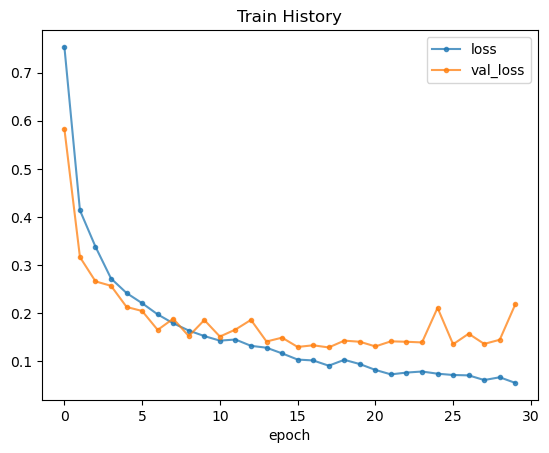

46/46 [==============================] - 0s 4ms/step - loss: 0.1777 - accuracy: 0.9474
8701
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6937 - accuracy: 0.6764 - val_loss: 0.3544 - val_accuracy: 0.8709
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3511 - accuracy: 0.8700 - val_loss: 0.2804 - val_accuracy: 0.8967
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2814 - accuracy: 0.8956 - val_loss: 0.2350 - val_accuracy: 0.9157
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2388 - accuracy: 0.9135 - val_loss: 0.2410 - val_accuracy: 0.9119
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2098 - accuracy: 0.9235 - val_loss: 0.1805 - val_accuracy: 0.9332
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1916 - accuracy: 0.9300 - val_loss: 0.1537 - val_accuracy: 0.9438
Epoch 7/30
186/186 [==============================

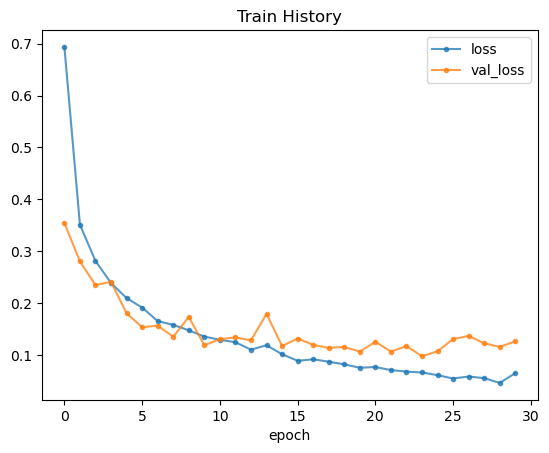

46/46 [==============================] - 0s 4ms/step - loss: 0.1176 - accuracy: 0.9556
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6691 - accuracy: 0.6908 - val_loss: 0.3540 - val_accuracy: 0.8633
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3196 - accuracy: 0.8803 - val_loss: 0.2375 - val_accuracy: 0.9195
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2566 - accuracy: 0.8998 - val_loss: 0.2365 - val_accuracy: 0.9119
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2301 - accuracy: 0.9162 - val_loss: 0.2149 - val_accuracy: 0.9119
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1969 - accuracy: 0.9266 - val_loss: 0.1817 - val_accuracy: 0.9256
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1742 - accuracy: 0.9367 - val_loss: 0.1518 - val_accuracy: 0.9385
Epoch 7/30
186/186 [==============================

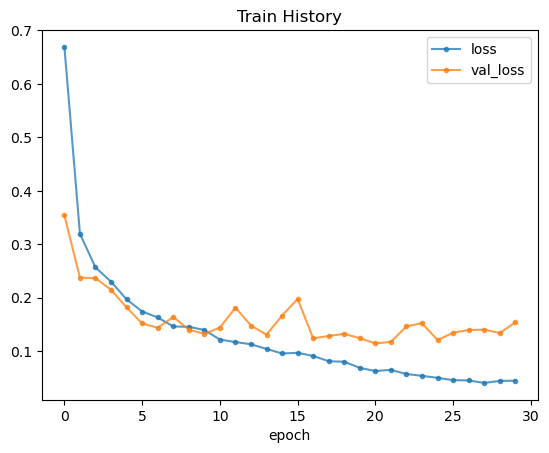

46/46 [==============================] - 0s 4ms/step - loss: 0.1416 - accuracy: 0.9583
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6882 - accuracy: 0.6863 - val_loss: 0.4328 - val_accuracy: 0.8405
Epoch 2/30
186/186 [==============================] - 3s 13ms/step - loss: 0.3617 - accuracy: 0.8603 - val_loss: 0.2988 - val_accuracy: 0.8869
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2865 - accuracy: 0.8925 - val_loss: 0.2936 - val_accuracy: 0.8945
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2647 - accuracy: 0.9014 - val_loss: 0.2533 - val_accuracy: 0.9036
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2439 - accuracy: 0.9096 - val_loss: 0.2268 - val_accuracy: 0.9089
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2175 - accuracy: 0.9170 - val_loss: 0.2485 - val_accuracy: 0.8983
Epoch 7/30
186/186 [==============================

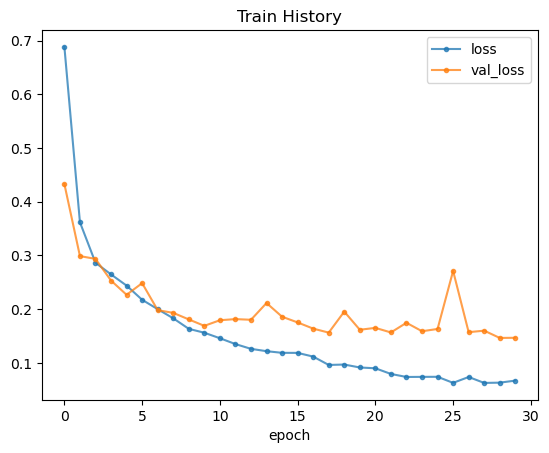

46/46 [==============================] - 0s 4ms/step - loss: 0.1191 - accuracy: 0.9651
-------------------------------
當前拋棄比例0.400000
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7018 - accuracy: 0.6878 - val_loss: 0.4077 - val_accuracy: 0.8383
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3893 - accuracy: 0.8516 - val_loss: 0.3183 - val_accuracy: 0.8838
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3036 - accuracy: 0.8862 - val_loss: 0.2388 - val_accuracy: 0.9127
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2796 - accuracy: 0.8982 - val_loss: 0.2706 - val_accuracy: 0.8884
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2611 - accuracy: 0.9022 - val_loss: 0.2088 - val_accuracy: 0.9286
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2294 - accuracy: 0.9135 - val_loss: 0.2124 - val_accuracy: 0.9218
Epo

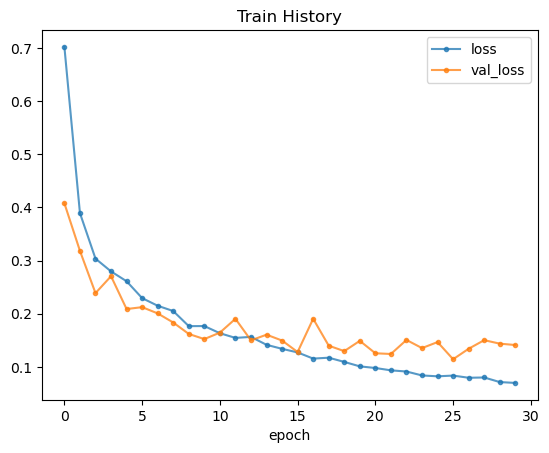

46/46 [==============================] - 0s 4ms/step - loss: 0.1155 - accuracy: 0.9528
8026
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7492 - accuracy: 0.6605 - val_loss: 0.3738 - val_accuracy: 0.8542
Epoch 2/30
186/186 [==============================] - 3s 13ms/step - loss: 0.3781 - accuracy: 0.8579 - val_loss: 0.2615 - val_accuracy: 0.9021
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2842 - accuracy: 0.8943 - val_loss: 0.2535 - val_accuracy: 0.8990
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2558 - accuracy: 0.9078 - val_loss: 0.1903 - val_accuracy: 0.9294
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2128 - accuracy: 0.9224 - val_loss: 0.1813 - val_accuracy: 0.9355
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2091 - accuracy: 0.9236 - val_loss: 0.1688 - val_accuracy: 0.9339
Epoch 7/30
186/186 [==============================

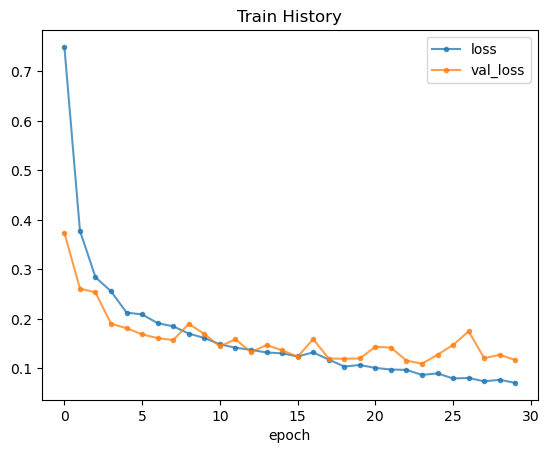

46/46 [==============================] - 0s 4ms/step - loss: 0.0933 - accuracy: 0.9658
8701
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.6607 - accuracy: 0.7186 - val_loss: 0.4496 - val_accuracy: 0.8193
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3838 - accuracy: 0.8544 - val_loss: 0.3542 - val_accuracy: 0.8595
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3057 - accuracy: 0.8852 - val_loss: 0.2332 - val_accuracy: 0.9203
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2572 - accuracy: 0.9044 - val_loss: 0.1904 - val_accuracy: 0.9355
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2194 - accuracy: 0.9189 - val_loss: 0.1821 - val_accuracy: 0.9355
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2144 - accuracy: 0.9215 - val_loss: 0.2222 - val_accuracy: 0.9119
Epoch 7/30
186/186 [==============================

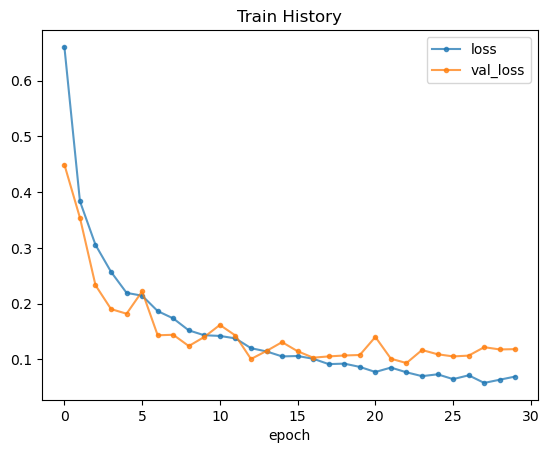

46/46 [==============================] - 0s 4ms/step - loss: 0.1166 - accuracy: 0.9563
7925
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.7648 - accuracy: 0.6543 - val_loss: 0.4129 - val_accuracy: 0.8512
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.4049 - accuracy: 0.8427 - val_loss: 0.3569 - val_accuracy: 0.8618
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3312 - accuracy: 0.8783 - val_loss: 0.2372 - val_accuracy: 0.9112
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2754 - accuracy: 0.9009 - val_loss: 0.2106 - val_accuracy: 0.9210
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2418 - accuracy: 0.9100 - val_loss: 0.1823 - val_accuracy: 0.9317
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2236 - accuracy: 0.9174 - val_loss: 0.1794 - val_accuracy: 0.9355
Epoch 7/30
186/186 [==============================

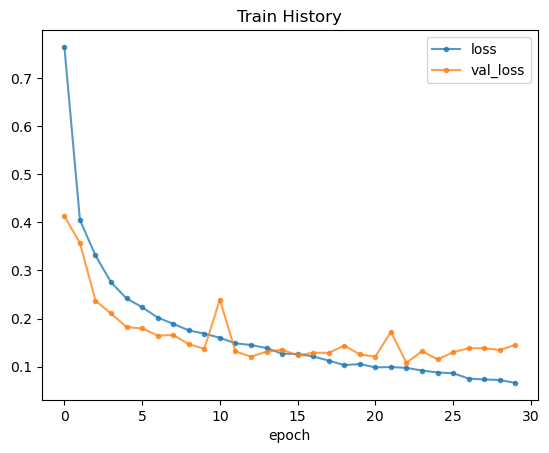

46/46 [==============================] - 0s 4ms/step - loss: 0.1354 - accuracy: 0.9610
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7500 - accuracy: 0.6630 - val_loss: 0.4506 - val_accuracy: 0.8208
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.4110 - accuracy: 0.8456 - val_loss: 0.2920 - val_accuracy: 0.8800
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3076 - accuracy: 0.8849 - val_loss: 0.2444 - val_accuracy: 0.9150
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2561 - accuracy: 0.9062 - val_loss: 0.1978 - val_accuracy: 0.9271
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2336 - accuracy: 0.9136 - val_loss: 0.1957 - val_accuracy: 0.9286
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2025 - accuracy: 0.9266 - val_loss: 0.1741 - val_accuracy: 0.9393
Epoch 7/30
186/186 [==============================

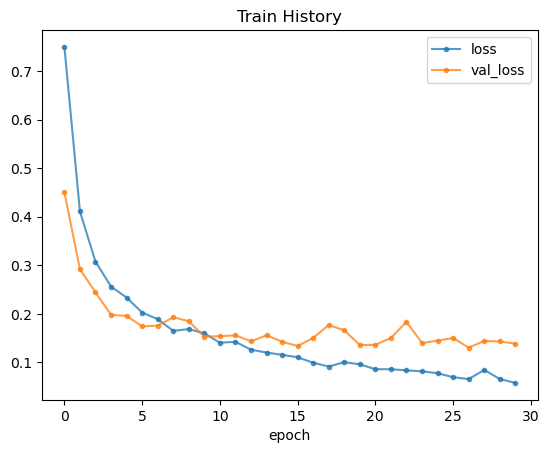

46/46 [==============================] - 0s 4ms/step - loss: 0.1187 - accuracy: 0.9617
-------------------------------
當前拋棄比例0.500000
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7476 - accuracy: 0.6486 - val_loss: 0.4581 - val_accuracy: 0.8064
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.4043 - accuracy: 0.8437 - val_loss: 0.2784 - val_accuracy: 0.9005
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3161 - accuracy: 0.8801 - val_loss: 0.2588 - val_accuracy: 0.9104
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2868 - accuracy: 0.8899 - val_loss: 0.2154 - val_accuracy: 0.9226
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2637 - accuracy: 0.8989 - val_loss: 0.2023 - val_accuracy: 0.9233
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2437 - accuracy: 0.9076 - val_loss: 0.1764 - val_accuracy: 0.9355
Epo

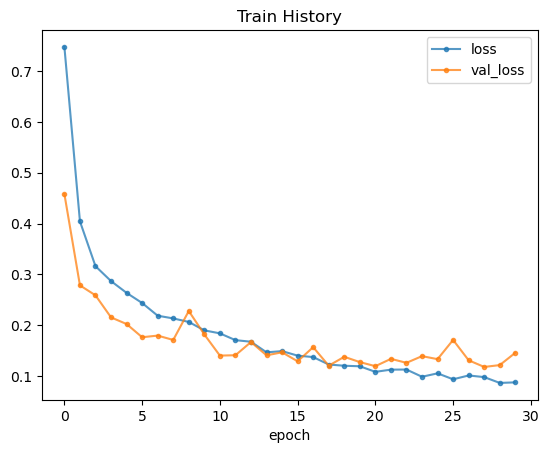

46/46 [==============================] - 0s 5ms/step - loss: 0.1396 - accuracy: 0.9515
8026
Epoch 1/30
186/186 [==============================] - 3s 17ms/step - loss: 0.7241 - accuracy: 0.6673 - val_loss: 0.5287 - val_accuracy: 0.7927
Epoch 2/30
186/186 [==============================] - 3s 16ms/step - loss: 0.4987 - accuracy: 0.8030 - val_loss: 0.3828 - val_accuracy: 0.8474
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3590 - accuracy: 0.8617 - val_loss: 0.2632 - val_accuracy: 0.9051
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2999 - accuracy: 0.8860 - val_loss: 0.2246 - val_accuracy: 0.9150
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2661 - accuracy: 0.8972 - val_loss: 0.1986 - val_accuracy: 0.9218
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2368 - accuracy: 0.9143 - val_loss: 0.1814 - val_accuracy: 0.9301
Epoch 7/30
186/186 [==============================

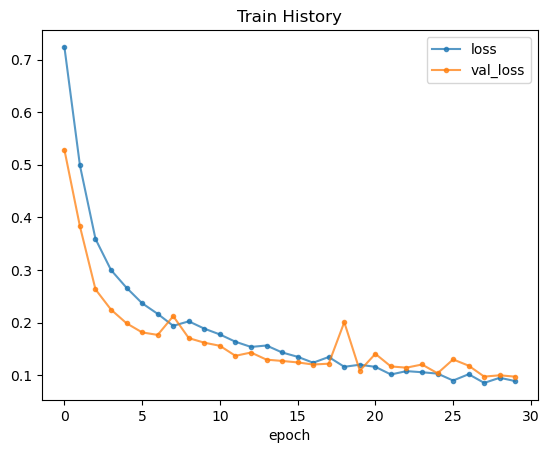

46/46 [==============================] - 0s 4ms/step - loss: 0.1188 - accuracy: 0.9624
8701
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7078 - accuracy: 0.6760 - val_loss: 0.3404 - val_accuracy: 0.8694
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3792 - accuracy: 0.8559 - val_loss: 0.2799 - val_accuracy: 0.9013
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3086 - accuracy: 0.8824 - val_loss: 0.2288 - val_accuracy: 0.9172
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2745 - accuracy: 0.8991 - val_loss: 0.2220 - val_accuracy: 0.9104
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2530 - accuracy: 0.9040 - val_loss: 0.2295 - val_accuracy: 0.9074
Epoch 6/30
186/186 [==============================] - 3s 13ms/step - loss: 0.2461 - accuracy: 0.9068 - val_loss: 0.2031 - val_accuracy: 0.9301
Epoch 7/30
186/186 [==============================

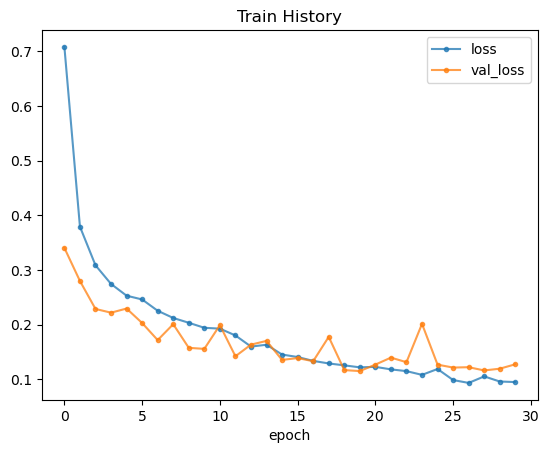

46/46 [==============================] - 0s 5ms/step - loss: 0.1198 - accuracy: 0.9535
8016
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.8346 - accuracy: 0.6041 - val_loss: 0.5001 - val_accuracy: 0.8064
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.4594 - accuracy: 0.8197 - val_loss: 0.3358 - val_accuracy: 0.8686
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3397 - accuracy: 0.8749 - val_loss: 0.2973 - val_accuracy: 0.8899
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3041 - accuracy: 0.8867 - val_loss: 0.2334 - val_accuracy: 0.9127
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2716 - accuracy: 0.8987 - val_loss: 0.2106 - val_accuracy: 0.9233
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2436 - accuracy: 0.9091 - val_loss: 0.1984 - val_accuracy: 0.9256
Epoch 7/30
186/186 [==============================

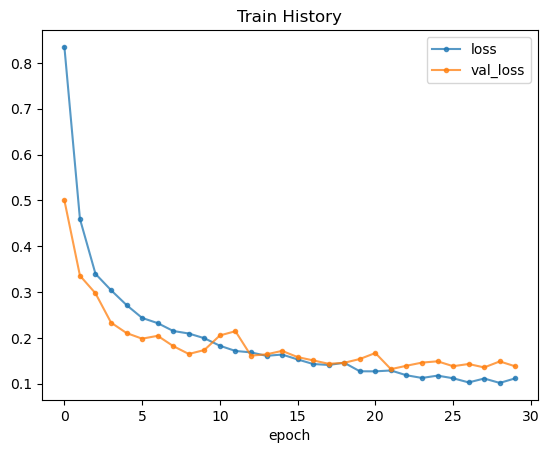

46/46 [==============================] - 0s 4ms/step - loss: 0.1226 - accuracy: 0.9549
8109
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6879 - accuracy: 0.6865 - val_loss: 0.3744 - val_accuracy: 0.8656
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3563 - accuracy: 0.8603 - val_loss: 0.2561 - val_accuracy: 0.9089
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2824 - accuracy: 0.8960 - val_loss: 0.2179 - val_accuracy: 0.9203
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2399 - accuracy: 0.9117 - val_loss: 0.1927 - val_accuracy: 0.9286
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2224 - accuracy: 0.9170 - val_loss: 0.2301 - val_accuracy: 0.9134
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2189 - accuracy: 0.9192 - val_loss: 0.1944 - val_accuracy: 0.9241
Epoch 7/30
186/186 [==============================

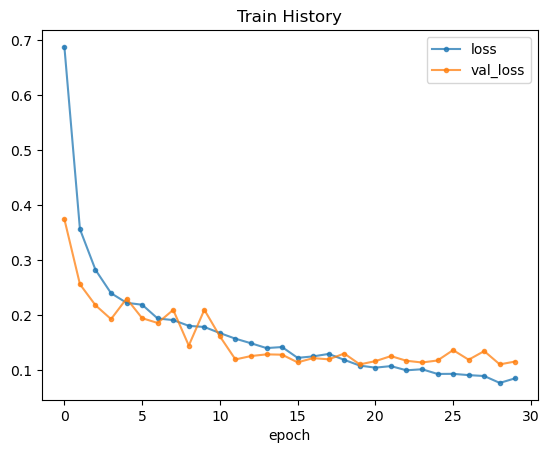

46/46 [==============================] - 0s 4ms/step - loss: 0.1079 - accuracy: 0.9583
[[0.16788148880004883, 0.948051929473877], [0.1846897304058075, 0.9439507722854614], [0.12877731025218964, 0.9617224931716919], [0.18558651208877563, 0.948051929473877], [0.14155595004558563, 0.9617224931716919], [0.12264788150787354, 0.9583048820495605], [0.17770254611968994, 0.9473684430122375], [0.11760159581899643, 0.9555707573890686], [0.14159737527370453, 0.9583048820495605], [0.11909991502761841, 0.9651401042938232], [0.11547651141881943, 0.9528366327285767], [0.09332025796175003, 0.9658236503601074], [0.11657924205064774, 0.956254243850708], [0.13540342450141907, 0.9610389471054077], [0.11867921054363251, 0.9617224931716919], [0.13959942758083344, 0.9514696002006531], [0.11884024739265442, 0.9624060392379761], [0.11980898678302765, 0.9535201787948608], [0.12262341380119324, 0.9548872113227844], [0.10786977410316467, 0.9583048820495605]]


In [24]:
score=[]
for drop in [0.2,0.3,0.4,0.5]:
    print("-------------------------------\n當前拋棄比例%f"%drop)
    for i in range(5):
        np.random.seed(i)
        reset_keras()
        model_CNN=Sequential()
        model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
        model_CNN.add(MaxPooling2D(pool_size=(2,2)))
        model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
        model_CNN.add(MaxPooling2D(pool_size=(2,2)))
        model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
        model_CNN.add(MaxPooling2D(pool_size=(2,2)))
        model_CNN.add(Dropout(drop))
        model_CNN.add(Flatten())
        model_CNN.add(Dense(units=32, activation='relu'))
        model_CNN.add(Dense(units=16, activation='relu'))
        model_CNN.add(Dense(units=3, activation='softmax'))
        model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        if i == 1:
            plot_model(model_CNN,show_shapes=True)
        train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=30,batch_size=64,verbose=1)
        plt.title("Train History")
        plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
        plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
        plt.xlabel("epoch")
        plt.legend(["loss","val_loss"])
        plt.show()
        score.append(model_CNN.evaluate(test_feature,test_label))
print(score)

## 實驗3-詳細調整拋棄比例(0.4-0.5)

-------------------------------
當前拋棄比例0.4
0
Epoch 1/30
186/186 [==============================] - 5s 14ms/step - loss: 0.7837 - accuracy: 0.6270 - val_loss: 0.4781 - val_accuracy: 0.8087
Epoch 2/30
186/186 [==============================] - 2s 12ms/step - loss: 0.4228 - accuracy: 0.8361 - val_loss: 0.3628 - val_accuracy: 0.8565
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3402 - accuracy: 0.8736 - val_loss: 0.2742 - val_accuracy: 0.8922
Epoch 4/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2932 - accuracy: 0.8897 - val_loss: 0.2737 - val_accuracy: 0.8914
Epoch 5/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2574 - accuracy: 0.9048 - val_loss: 0.1929 - val_accuracy: 0.9286
Epoch 6/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2220 - accuracy: 0.9155 - val_loss: 0.1824 - val_accuracy: 0.9347
Epoch 7/30
186/186 [==============================] - 2s 12ms/step - loss: 0.1987 - accuracy: 0.92

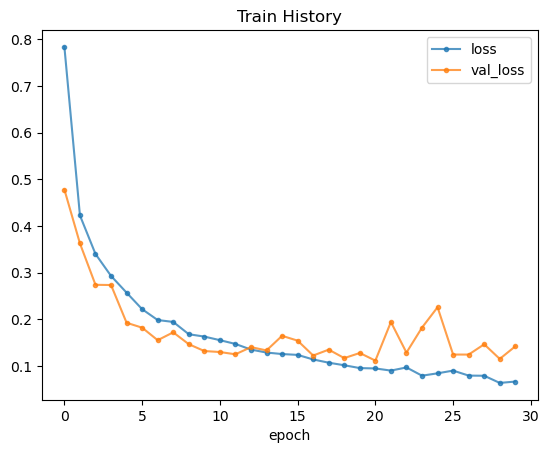

46/46 [==============================] - 0s 5ms/step - loss: 0.1168 - accuracy: 0.9597
2414
Epoch 1/30
186/186 [==============================] - 3s 13ms/step - loss: 0.7036 - accuracy: 0.6881 - val_loss: 0.4778 - val_accuracy: 0.8026
Epoch 2/30
186/186 [==============================] - 2s 12ms/step - loss: 0.4030 - accuracy: 0.8424 - val_loss: 0.2934 - val_accuracy: 0.8861
Epoch 3/30
186/186 [==============================] - 2s 12ms/step - loss: 0.3122 - accuracy: 0.8821 - val_loss: 0.2635 - val_accuracy: 0.9058
Epoch 4/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2680 - accuracy: 0.8990 - val_loss: 0.2334 - val_accuracy: 0.9142
Epoch 5/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2322 - accuracy: 0.9130 - val_loss: 0.1878 - val_accuracy: 0.9263
Epoch 6/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2121 - accuracy: 0.9194 - val_loss: 0.1638 - val_accuracy: 0.9370
Epoch 7/30
186/186 [==============================

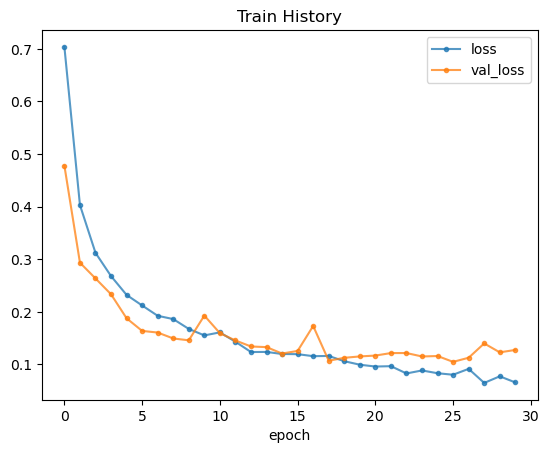

46/46 [==============================] - 0s 4ms/step - loss: 0.1226 - accuracy: 0.9631
10910
Epoch 1/30
186/186 [==============================] - 3s 13ms/step - loss: 0.6917 - accuracy: 0.6873 - val_loss: 0.3417 - val_accuracy: 0.8641
Epoch 2/30
186/186 [==============================] - 2s 12ms/step - loss: 0.3444 - accuracy: 0.8717 - val_loss: 0.2620 - val_accuracy: 0.9036
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2991 - accuracy: 0.8878 - val_loss: 0.2369 - val_accuracy: 0.9081
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2603 - accuracy: 0.9041 - val_loss: 0.2824 - val_accuracy: 0.8929
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2365 - accuracy: 0.9119 - val_loss: 0.1989 - val_accuracy: 0.9248
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2065 - accuracy: 0.9209 - val_loss: 0.1935 - val_accuracy: 0.9248
Epoch 7/30
186/186 [=============================

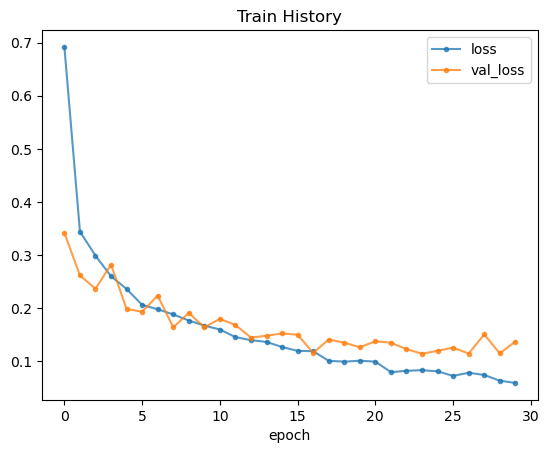

46/46 [==============================] - 0s 4ms/step - loss: 0.1438 - accuracy: 0.9481
8016
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.7433 - accuracy: 0.6620 - val_loss: 0.4406 - val_accuracy: 0.8284
Epoch 2/30
186/186 [==============================] - 3s 13ms/step - loss: 0.4140 - accuracy: 0.8397 - val_loss: 0.2919 - val_accuracy: 0.8853
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3098 - accuracy: 0.8846 - val_loss: 0.2559 - val_accuracy: 0.9036
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2618 - accuracy: 0.9058 - val_loss: 0.2270 - val_accuracy: 0.9127
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2426 - accuracy: 0.9102 - val_loss: 0.2235 - val_accuracy: 0.9150
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2221 - accuracy: 0.9178 - val_loss: 0.2336 - val_accuracy: 0.9127
Epoch 7/30
186/186 [==============================

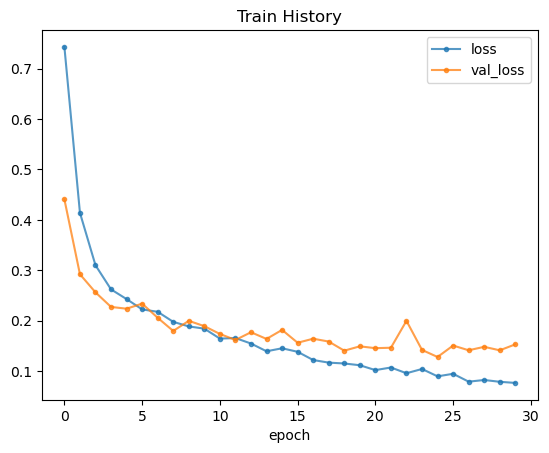

46/46 [==============================] - 0s 4ms/step - loss: 0.1457 - accuracy: 0.9535
8026
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6544 - accuracy: 0.7209 - val_loss: 0.4871 - val_accuracy: 0.8109
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3929 - accuracy: 0.8546 - val_loss: 0.3169 - val_accuracy: 0.8755
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3265 - accuracy: 0.8792 - val_loss: 0.2728 - val_accuracy: 0.8945
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2732 - accuracy: 0.8968 - val_loss: 0.2486 - val_accuracy: 0.9013
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2434 - accuracy: 0.9076 - val_loss: 0.2212 - val_accuracy: 0.9256
Epoch 6/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2085 - accuracy: 0.9209 - val_loss: 0.1780 - val_accuracy: 0.9446
Epoch 7/30
186/186 [==============================

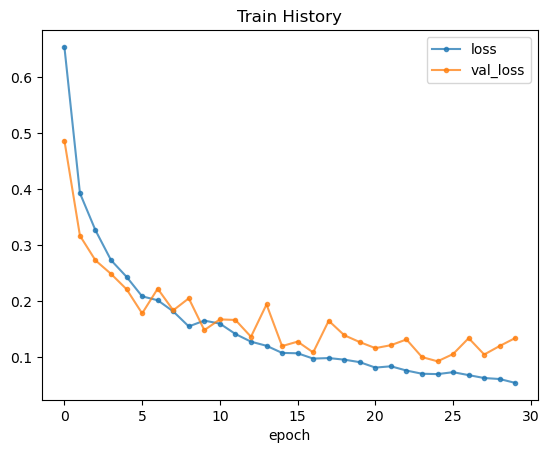

46/46 [==============================] - 0s 4ms/step - loss: 0.1685 - accuracy: 0.9453
-------------------------------
當前拋棄比例0.4
7901
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7230 - accuracy: 0.6697 - val_loss: 0.4423 - val_accuracy: 0.8299
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3714 - accuracy: 0.8608 - val_loss: 0.3214 - val_accuracy: 0.8747
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2959 - accuracy: 0.8903 - val_loss: 0.2811 - val_accuracy: 0.8891
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2528 - accuracy: 0.9065 - val_loss: 0.2331 - val_accuracy: 0.9119
Epoch 5/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2343 - accuracy: 0.9105 - val_loss: 0.2092 - val_accuracy: 0.9203
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2188 - accuracy: 0.9186 - val_loss: 0.2212 - val_accuracy: 0.9165
Epoch 7/

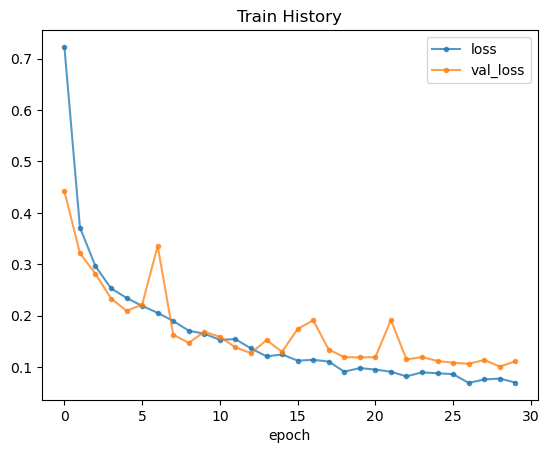

46/46 [==============================] - 0s 4ms/step - loss: 0.0985 - accuracy: 0.9651
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6971 - accuracy: 0.6807 - val_loss: 0.4135 - val_accuracy: 0.8451
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3839 - accuracy: 0.8519 - val_loss: 0.3647 - val_accuracy: 0.8565
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3124 - accuracy: 0.8816 - val_loss: 0.3182 - val_accuracy: 0.8770
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2694 - accuracy: 0.8989 - val_loss: 0.2089 - val_accuracy: 0.9203
Epoch 5/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2531 - accuracy: 0.9035 - val_loss: 0.2600 - val_accuracy: 0.9134
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2207 - accuracy: 0.9176 - val_loss: 0.1880 - val_accuracy: 0.9233
Epoch 7/30
186/186 [==============================

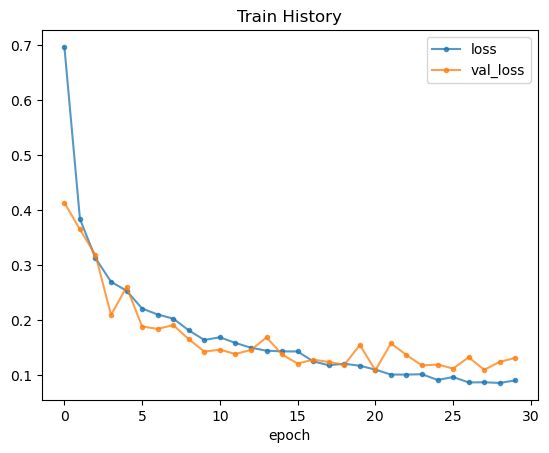

46/46 [==============================] - 0s 4ms/step - loss: 0.1255 - accuracy: 0.9487
8701
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.8052 - accuracy: 0.6123 - val_loss: 0.4787 - val_accuracy: 0.8003
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3948 - accuracy: 0.8519 - val_loss: 0.3187 - val_accuracy: 0.8815
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2826 - accuracy: 0.8967 - val_loss: 0.2019 - val_accuracy: 0.9309
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2434 - accuracy: 0.9114 - val_loss: 0.1883 - val_accuracy: 0.9339
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2136 - accuracy: 0.9239 - val_loss: 0.1850 - val_accuracy: 0.9332
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.1966 - accuracy: 0.9289 - val_loss: 0.1535 - val_accuracy: 0.9453
Epoch 7/30
186/186 [==============================

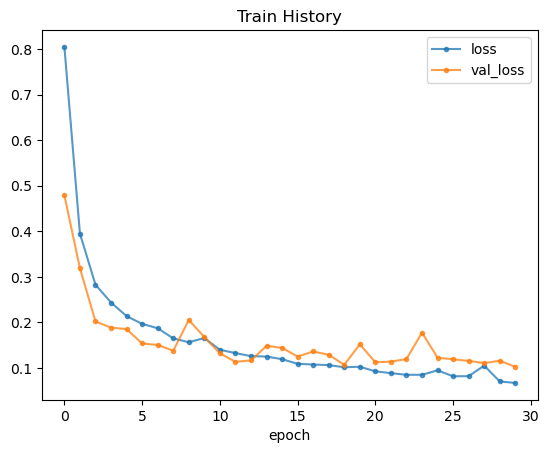

46/46 [==============================] - 0s 5ms/step - loss: 0.0825 - accuracy: 0.9679
8109
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.6708 - accuracy: 0.6955 - val_loss: 0.4645 - val_accuracy: 0.8140
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3716 - accuracy: 0.8573 - val_loss: 0.2929 - val_accuracy: 0.8884
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3008 - accuracy: 0.8866 - val_loss: 0.2953 - val_accuracy: 0.8808
Epoch 4/30
186/186 [==============================] - 3s 13ms/step - loss: 0.2609 - accuracy: 0.9045 - val_loss: 0.2013 - val_accuracy: 0.9279
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2233 - accuracy: 0.9183 - val_loss: 0.1817 - val_accuracy: 0.9332
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2041 - accuracy: 0.9251 - val_loss: 0.1671 - val_accuracy: 0.9347
Epoch 7/30
186/186 [==============================

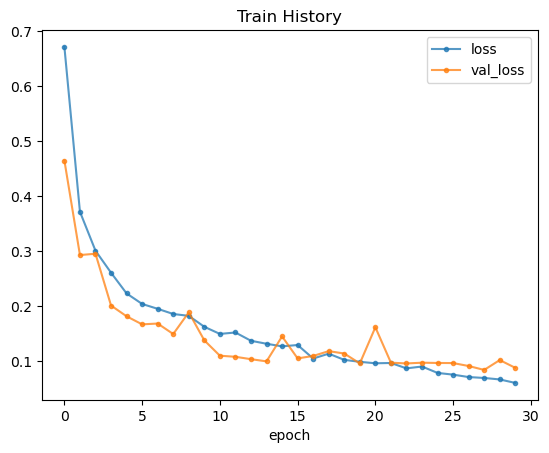

46/46 [==============================] - 0s 4ms/step - loss: 0.0920 - accuracy: 0.9665
8026
Epoch 1/30
186/186 [==============================] - 3s 13ms/step - loss: 0.7156 - accuracy: 0.6778 - val_loss: 0.3737 - val_accuracy: 0.8595
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3931 - accuracy: 0.8538 - val_loss: 0.3208 - val_accuracy: 0.8747
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3215 - accuracy: 0.8772 - val_loss: 0.2902 - val_accuracy: 0.8899
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2894 - accuracy: 0.8925 - val_loss: 0.3694 - val_accuracy: 0.8641
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2577 - accuracy: 0.9039 - val_loss: 0.2137 - val_accuracy: 0.9263
Epoch 6/30
186/186 [==============================] - 3s 13ms/step - loss: 0.2321 - accuracy: 0.9162 - val_loss: 0.2072 - val_accuracy: 0.9279
Epoch 7/30
186/186 [==============================

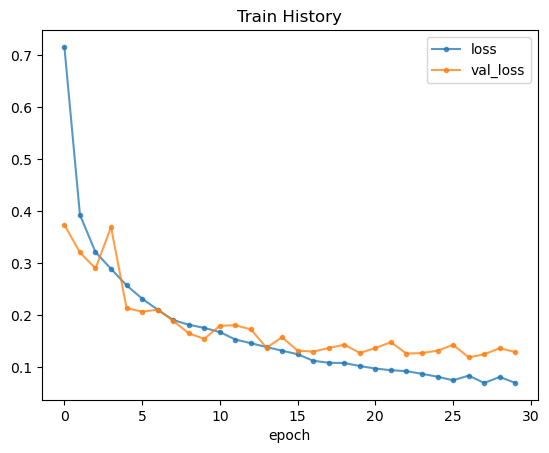

46/46 [==============================] - 0s 4ms/step - loss: 0.1507 - accuracy: 0.9494
-------------------------------
當前拋棄比例0.5
8016
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.6088 - accuracy: 0.7386 - val_loss: 0.3312 - val_accuracy: 0.8853
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3198 - accuracy: 0.8819 - val_loss: 0.2533 - val_accuracy: 0.9028
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2719 - accuracy: 0.8980 - val_loss: 0.2777 - val_accuracy: 0.8983
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2393 - accuracy: 0.9089 - val_loss: 0.2096 - val_accuracy: 0.9263
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2196 - accuracy: 0.9191 - val_loss: 0.2077 - val_accuracy: 0.9263
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2023 - accuracy: 0.9263 - val_loss: 0.1841 - val_accuracy: 0.9317
Epoch 7/

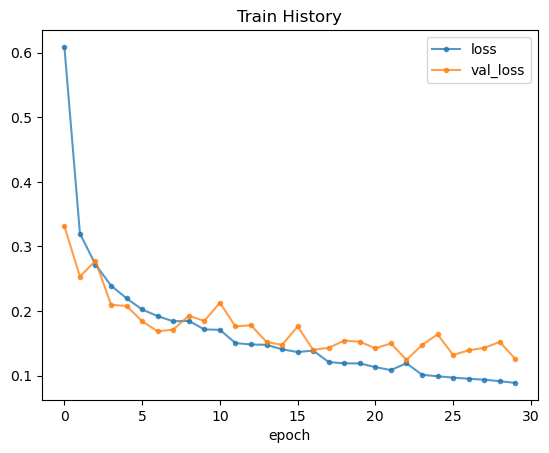

46/46 [==============================] - 0s 5ms/step - loss: 0.1288 - accuracy: 0.9590
7917
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.7347 - accuracy: 0.6718 - val_loss: 0.4235 - val_accuracy: 0.8436
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3942 - accuracy: 0.8516 - val_loss: 0.3197 - val_accuracy: 0.8846
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3185 - accuracy: 0.8805 - val_loss: 0.2326 - val_accuracy: 0.9150
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2793 - accuracy: 0.8942 - val_loss: 0.2258 - val_accuracy: 0.9210
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2430 - accuracy: 0.9098 - val_loss: 0.1962 - val_accuracy: 0.9263
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2224 - accuracy: 0.9166 - val_loss: 0.1794 - val_accuracy: 0.9385
Epoch 7/30
186/186 [==============================

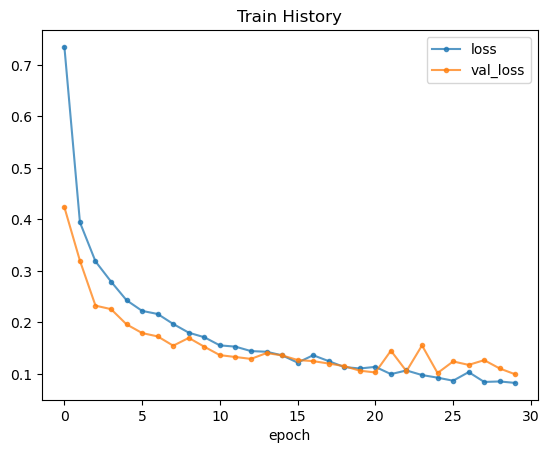

46/46 [==============================] - 0s 4ms/step - loss: 0.1011 - accuracy: 0.9590
8701
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.6885 - accuracy: 0.6891 - val_loss: 0.3541 - val_accuracy: 0.8565
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3578 - accuracy: 0.8670 - val_loss: 0.2694 - val_accuracy: 0.8914
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2923 - accuracy: 0.8935 - val_loss: 0.2394 - val_accuracy: 0.9134
Epoch 4/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2426 - accuracy: 0.9086 - val_loss: 0.2402 - val_accuracy: 0.9066
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2265 - accuracy: 0.9167 - val_loss: 0.1935 - val_accuracy: 0.9279
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2100 - accuracy: 0.9227 - val_loss: 0.1893 - val_accuracy: 0.9317
Epoch 7/30
186/186 [==============================

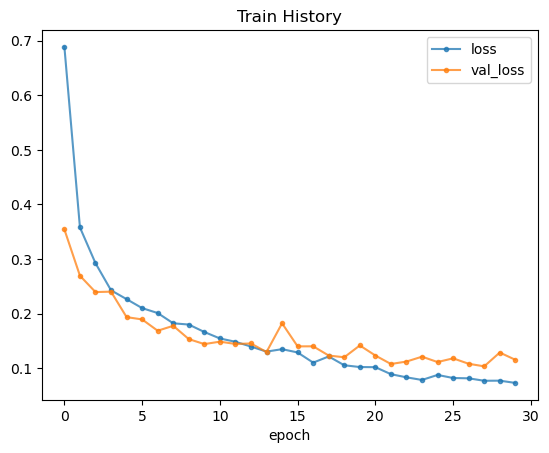

46/46 [==============================] - 0s 4ms/step - loss: 0.1108 - accuracy: 0.9597
8016
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.7479 - accuracy: 0.6625 - val_loss: 0.4848 - val_accuracy: 0.8193
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.4267 - accuracy: 0.8338 - val_loss: 0.3418 - val_accuracy: 0.8702
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3266 - accuracy: 0.8750 - val_loss: 0.2606 - val_accuracy: 0.9051
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2727 - accuracy: 0.8975 - val_loss: 0.2441 - val_accuracy: 0.9096
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2371 - accuracy: 0.9079 - val_loss: 0.1833 - val_accuracy: 0.9248
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2040 - accuracy: 0.9236 - val_loss: 0.2113 - val_accuracy: 0.9165
Epoch 7/30
186/186 [==============================

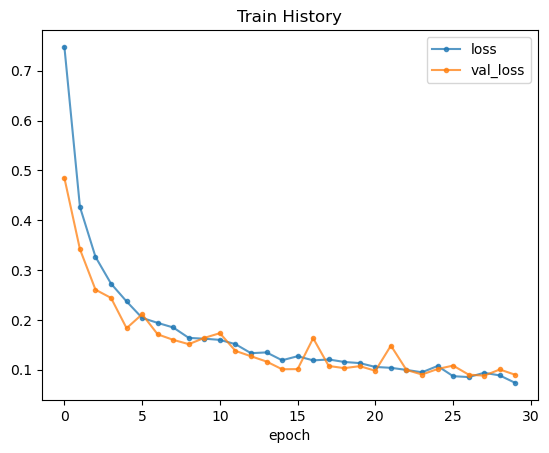

46/46 [==============================] - 0s 4ms/step - loss: 0.0853 - accuracy: 0.9658
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7206 - accuracy: 0.6786 - val_loss: 0.5003 - val_accuracy: 0.7957
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3930 - accuracy: 0.8479 - val_loss: 0.2715 - val_accuracy: 0.8990
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2877 - accuracy: 0.8901 - val_loss: 0.2419 - val_accuracy: 0.9150
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2393 - accuracy: 0.9082 - val_loss: 0.2335 - val_accuracy: 0.9028
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2216 - accuracy: 0.9165 - val_loss: 0.1757 - val_accuracy: 0.9324
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.1949 - accuracy: 0.9263 - val_loss: 0.1694 - val_accuracy: 0.9377
Epoch 7/30
186/186 [==============================

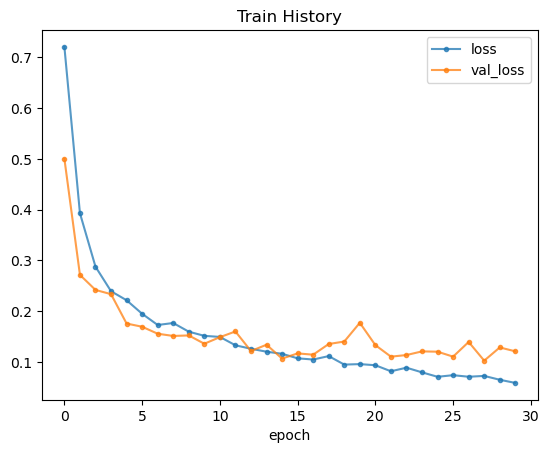

46/46 [==============================] - 0s 4ms/step - loss: 0.1161 - accuracy: 0.9638
-------------------------------
當前拋棄比例0.5
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7291 - accuracy: 0.6763 - val_loss: 0.4430 - val_accuracy: 0.8443
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.4327 - accuracy: 0.8317 - val_loss: 0.3438 - val_accuracy: 0.8626
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3568 - accuracy: 0.8617 - val_loss: 0.3038 - val_accuracy: 0.8869
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3094 - accuracy: 0.8814 - val_loss: 0.2595 - val_accuracy: 0.9043
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2755 - accuracy: 0.8960 - val_loss: 0.2422 - val_accuracy: 0.9096
Epoch 6/30
186/186 [==============================] - 3s 16ms/step - loss: 0.2558 - accuracy: 0.9028 - val_loss: 0.2890 - val_accuracy: 0.8952
Epoch 7/

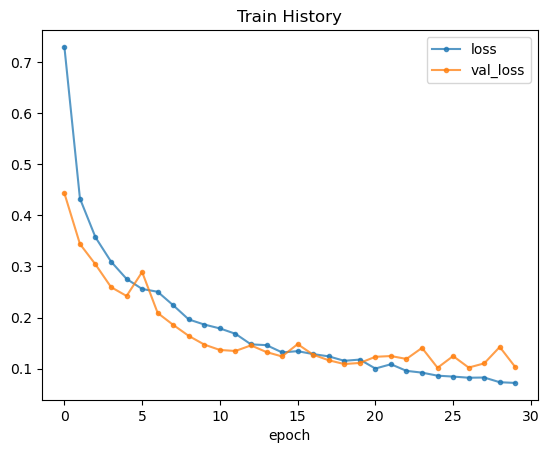

46/46 [==============================] - 0s 4ms/step - loss: 0.1033 - accuracy: 0.9638
8016
Epoch 1/30
186/186 [==============================] - 3s 13ms/step - loss: 0.6837 - accuracy: 0.6941 - val_loss: 0.4921 - val_accuracy: 0.8208
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.4053 - accuracy: 0.8445 - val_loss: 0.3346 - val_accuracy: 0.8785
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3164 - accuracy: 0.8792 - val_loss: 0.3058 - val_accuracy: 0.8891
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2803 - accuracy: 0.8968 - val_loss: 0.2467 - val_accuracy: 0.9127
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2473 - accuracy: 0.9077 - val_loss: 0.2224 - val_accuracy: 0.9195
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2200 - accuracy: 0.9157 - val_loss: 0.2143 - val_accuracy: 0.9248
Epoch 7/30
186/186 [==============================

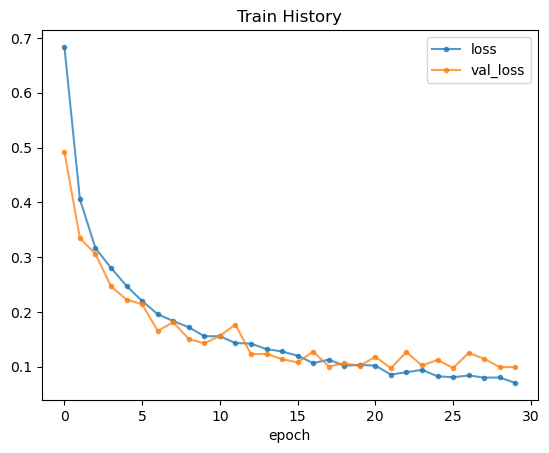

46/46 [==============================] - 0s 4ms/step - loss: 0.1060 - accuracy: 0.9617
8701
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.7255 - accuracy: 0.6748 - val_loss: 0.4314 - val_accuracy: 0.8284
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3937 - accuracy: 0.8494 - val_loss: 0.3197 - val_accuracy: 0.8808
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3426 - accuracy: 0.8698 - val_loss: 0.2732 - val_accuracy: 0.8967
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2711 - accuracy: 0.9003 - val_loss: 0.2357 - val_accuracy: 0.9134
Epoch 5/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2522 - accuracy: 0.9074 - val_loss: 0.2047 - val_accuracy: 0.9188
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2353 - accuracy: 0.9125 - val_loss: 0.2500 - val_accuracy: 0.8975
Epoch 7/30
186/186 [==============================

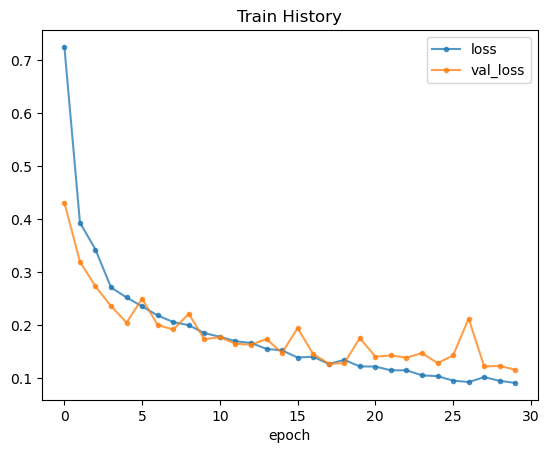

46/46 [==============================] - 0s 4ms/step - loss: 0.0881 - accuracy: 0.9665
8016
Epoch 1/30
186/186 [==============================] - 3s 16ms/step - loss: 0.7272 - accuracy: 0.6705 - val_loss: 0.4392 - val_accuracy: 0.8299
Epoch 2/30
186/186 [==============================] - 3s 15ms/step - loss: 0.4381 - accuracy: 0.8325 - val_loss: 0.3654 - val_accuracy: 0.8641
Epoch 3/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3705 - accuracy: 0.8601 - val_loss: 0.3078 - val_accuracy: 0.8907
Epoch 4/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3263 - accuracy: 0.8782 - val_loss: 0.2510 - val_accuracy: 0.9157
Epoch 5/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2911 - accuracy: 0.8886 - val_loss: 0.2488 - val_accuracy: 0.9112
Epoch 6/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2688 - accuracy: 0.8975 - val_loss: 0.2115 - val_accuracy: 0.9218
Epoch 7/30
186/186 [==============================

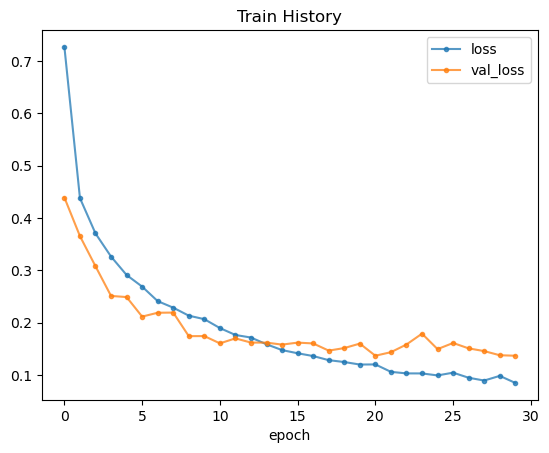

46/46 [==============================] - 0s 5ms/step - loss: 0.1268 - accuracy: 0.9494
8016
Epoch 1/30
186/186 [==============================] - 3s 17ms/step - loss: 0.6816 - accuracy: 0.7006 - val_loss: 0.4110 - val_accuracy: 0.8481
Epoch 2/30
186/186 [==============================] - 3s 15ms/step - loss: 0.4045 - accuracy: 0.8479 - val_loss: 0.3067 - val_accuracy: 0.8869
Epoch 3/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3225 - accuracy: 0.8800 - val_loss: 0.2461 - val_accuracy: 0.9195
Epoch 4/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2905 - accuracy: 0.8914 - val_loss: 0.2528 - val_accuracy: 0.9134
Epoch 5/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2585 - accuracy: 0.9050 - val_loss: 0.2323 - val_accuracy: 0.9233
Epoch 6/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2302 - accuracy: 0.9162 - val_loss: 0.2025 - val_accuracy: 0.9218
Epoch 7/30
186/186 [==============================

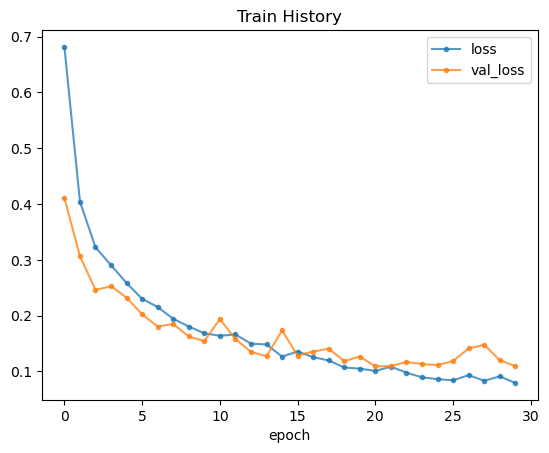

46/46 [==============================] - 0s 5ms/step - loss: 0.0951 - accuracy: 0.9638
-------------------------------
當前拋棄比例0.5
8016
Epoch 1/30
186/186 [==============================] - 3s 17ms/step - loss: 0.7370 - accuracy: 0.6635 - val_loss: 0.4432 - val_accuracy: 0.8352
Epoch 2/30
186/186 [==============================] - 3s 16ms/step - loss: 0.4160 - accuracy: 0.8386 - val_loss: 0.3015 - val_accuracy: 0.8853
Epoch 3/30
186/186 [==============================] - 3s 16ms/step - loss: 0.3233 - accuracy: 0.8771 - val_loss: 0.2563 - val_accuracy: 0.9104
Epoch 4/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2783 - accuracy: 0.8949 - val_loss: 0.2517 - val_accuracy: 0.9089
Epoch 5/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2361 - accuracy: 0.9122 - val_loss: 0.2152 - val_accuracy: 0.9203
Epoch 6/30
186/186 [==============================] - 3s 16ms/step - loss: 0.2198 - accuracy: 0.9197 - val_loss: 0.2012 - val_accuracy: 0.9195
Epoch 7/

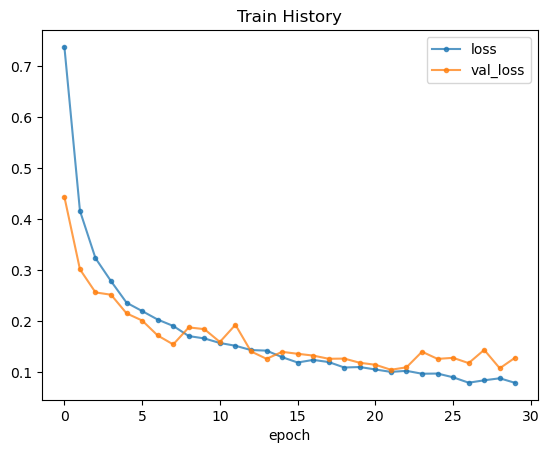

46/46 [==============================] - 0s 5ms/step - loss: 0.1147 - accuracy: 0.9651
8016
Epoch 1/30
186/186 [==============================] - 3s 16ms/step - loss: 0.6729 - accuracy: 0.7057 - val_loss: 0.4167 - val_accuracy: 0.8390
Epoch 2/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3864 - accuracy: 0.8538 - val_loss: 0.2944 - val_accuracy: 0.8808
Epoch 3/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3261 - accuracy: 0.8796 - val_loss: 0.2810 - val_accuracy: 0.8998
Epoch 4/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2859 - accuracy: 0.8938 - val_loss: 0.2462 - val_accuracy: 0.9058
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2712 - accuracy: 0.9005 - val_loss: 0.2370 - val_accuracy: 0.9096
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2425 - accuracy: 0.9080 - val_loss: 0.2028 - val_accuracy: 0.9241
Epoch 7/30
186/186 [==============================

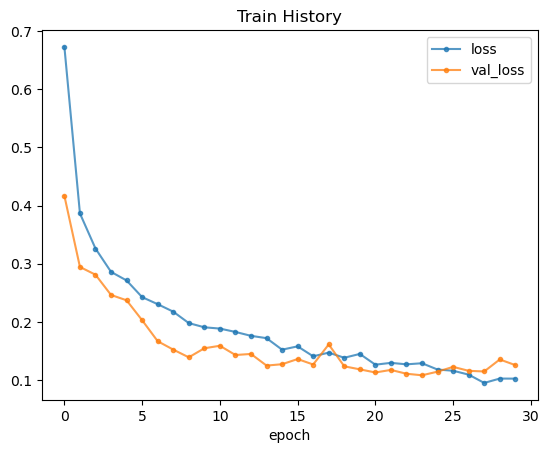

46/46 [==============================] - 0s 5ms/step - loss: 0.1264 - accuracy: 0.9556
8701
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6875 - accuracy: 0.6911 - val_loss: 0.3727 - val_accuracy: 0.8709
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.4035 - accuracy: 0.8459 - val_loss: 0.2871 - val_accuracy: 0.8983
Epoch 3/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3257 - accuracy: 0.8781 - val_loss: 0.2685 - val_accuracy: 0.9036
Epoch 4/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2765 - accuracy: 0.8980 - val_loss: 0.2173 - val_accuracy: 0.9157
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2474 - accuracy: 0.9084 - val_loss: 0.2189 - val_accuracy: 0.9172
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2412 - accuracy: 0.9120 - val_loss: 0.2166 - val_accuracy: 0.9188
Epoch 7/30
186/186 [==============================

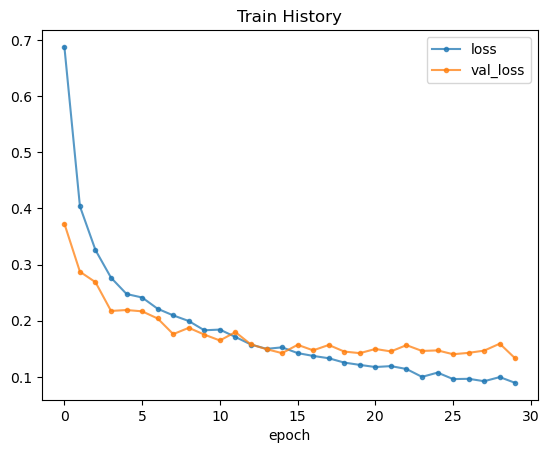

46/46 [==============================] - 0s 5ms/step - loss: 0.1103 - accuracy: 0.9542
8016
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6243 - accuracy: 0.7256 - val_loss: 0.3961 - val_accuracy: 0.8504
Epoch 2/30
186/186 [==============================] - 2s 13ms/step - loss: 0.3571 - accuracy: 0.8641 - val_loss: 0.2888 - val_accuracy: 0.8884
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3023 - accuracy: 0.8855 - val_loss: 0.2680 - val_accuracy: 0.8990
Epoch 4/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2685 - accuracy: 0.8992 - val_loss: 0.2669 - val_accuracy: 0.8975
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2376 - accuracy: 0.9078 - val_loss: 0.2153 - val_accuracy: 0.9188
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2164 - accuracy: 0.9199 - val_loss: 0.1985 - val_accuracy: 0.9271
Epoch 7/30
186/186 [==============================

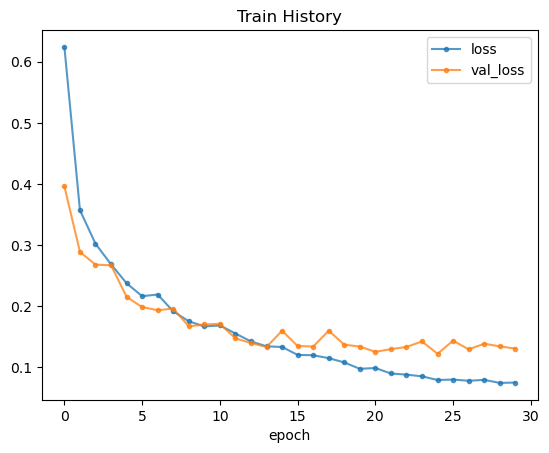

46/46 [==============================] - 0s 5ms/step - loss: 0.0947 - accuracy: 0.9692
7925
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.8238 - accuracy: 0.5912 - val_loss: 0.4716 - val_accuracy: 0.8170
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.4350 - accuracy: 0.8327 - val_loss: 0.4394 - val_accuracy: 0.8216
Epoch 3/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3580 - accuracy: 0.8653 - val_loss: 0.2892 - val_accuracy: 0.8922
Epoch 4/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3028 - accuracy: 0.8861 - val_loss: 0.2545 - val_accuracy: 0.9013
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2896 - accuracy: 0.8932 - val_loss: 0.2332 - val_accuracy: 0.9180
Epoch 6/30
186/186 [==============================] - 2s 12ms/step - loss: 0.2682 - accuracy: 0.9001 - val_loss: 0.2166 - val_accuracy: 0.9188
Epoch 7/30
186/186 [==============================

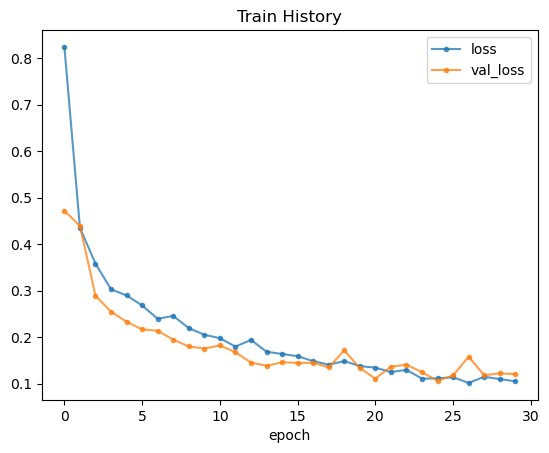

46/46 [==============================] - 0s 5ms/step - loss: 0.1236 - accuracy: 0.9556
[[0.11675328761339188, 0.9596719145774841], [0.12258587777614594, 0.9630895256996155], [0.14382193982601166, 0.948051929473877], [0.14569233357906342, 0.9535201787948608], [0.16848301887512207, 0.9453178644180298], [0.09846611320972443, 0.9651401042938232], [0.12545065581798553, 0.9487354755401611], [0.0824536383152008, 0.9678742289543152], [0.09200149774551392, 0.9665071964263916], [0.15068954229354858, 0.9494190216064453], [0.12882649898529053, 0.9589883685112], [0.1011359840631485, 0.9589883685112], [0.11079873889684677, 0.9596719145774841], [0.08526156097650528, 0.9658236503601074], [0.11612773686647415, 0.9637730717658997], [0.10325183719396591, 0.9637730717658997], [0.10596347600221634, 0.9617224931716919], [0.08810870349407196, 0.9665071964263916], [0.1268237680196762, 0.9494190216064453], [0.09511697292327881, 0.9637730717658997], [0.11474614590406418, 0.9651401042938232], [0.1263688653707504

In [6]:
score=[]
for drop in [0.4,0.43,0.45,0.47,0.5]:
    print("-------------------------------\n當前拋棄比例%.1f"%drop)
    for i in range(5):
        np.random.seed(i)
        reset_keras()
        model_CNN=Sequential()
        model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
        model_CNN.add(MaxPooling2D(pool_size=(2,2)))
        model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
        model_CNN.add(MaxPooling2D(pool_size=(2,2)))
        model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
        model_CNN.add(MaxPooling2D(pool_size=(2,2)))
        model_CNN.add(Dropout(drop))
        model_CNN.add(Flatten())
        model_CNN.add(Dense(units=32, activation='relu'))
        model_CNN.add(Dense(units=16, activation='relu'))
        model_CNN.add(Dense(units=3, activation='softmax'))
        model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        if i == 1:
            plot_model(model_CNN,show_shapes=True)
        train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=30,batch_size=64,verbose=1)
        plt.title("Train History")
        plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
        plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
        plt.xlabel("epoch")
        plt.legend(["loss","val_loss"])
        plt.show()
        score.append(model_CNN.evaluate(test_feature,test_label))
print(score)

## 實驗4-訓練參數比較(batch_size)

-------------------------------
當前batch_size=32
80
Epoch 1/30
371/371 [==============================] - 4s 9ms/step - loss: 0.6669 - accuracy: 0.7030 - val_loss: 0.3977 - val_accuracy: 0.8421
Epoch 2/30
371/371 [==============================] - 3s 9ms/step - loss: 0.3352 - accuracy: 0.8693 - val_loss: 0.2666 - val_accuracy: 0.9021
Epoch 3/30
371/371 [==============================] - 3s 8ms/step - loss: 0.2532 - accuracy: 0.9054 - val_loss: 0.1933 - val_accuracy: 0.9324
Epoch 4/30
371/371 [==============================] - 3s 8ms/step - loss: 0.2128 - accuracy: 0.9211 - val_loss: 0.1800 - val_accuracy: 0.9324
Epoch 5/30
371/371 [==============================] - 3s 9ms/step - loss: 0.1873 - accuracy: 0.9322 - val_loss: 0.1555 - val_accuracy: 0.9446
Epoch 6/30
371/371 [==============================] - 3s 8ms/step - loss: 0.1785 - accuracy: 0.9331 - val_loss: 0.1806 - val_accuracy: 0.9431
Epoch 7/30
371/371 [==============================] - 3s 8ms/step - loss: 0.1525 - accuracy: 0.94

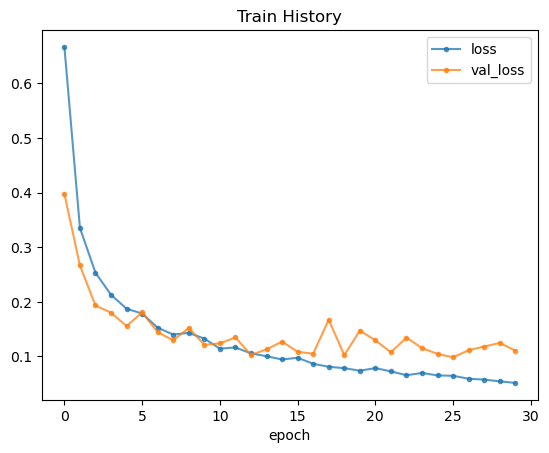

46/46 [==============================] - 0s 5ms/step - loss: 0.1250 - accuracy: 0.9617
7897
Epoch 1/30
371/371 [==============================] - 4s 9ms/step - loss: 0.6441 - accuracy: 0.7214 - val_loss: 0.3400 - val_accuracy: 0.8755
Epoch 2/30
371/371 [==============================] - 3s 8ms/step - loss: 0.3753 - accuracy: 0.8592 - val_loss: 0.2692 - val_accuracy: 0.9028
Epoch 3/30
371/371 [==============================] - 3s 9ms/step - loss: 0.3101 - accuracy: 0.8839 - val_loss: 0.2306 - val_accuracy: 0.9134
Epoch 4/30
371/371 [==============================] - 3s 9ms/step - loss: 0.2625 - accuracy: 0.9029 - val_loss: 0.1915 - val_accuracy: 0.9332
Epoch 5/30
371/371 [==============================] - 4s 10ms/step - loss: 0.2289 - accuracy: 0.9142 - val_loss: 0.2311 - val_accuracy: 0.9119
Epoch 6/30
371/371 [==============================] - 3s 9ms/step - loss: 0.2199 - accuracy: 0.9194 - val_loss: 0.1901 - val_accuracy: 0.9301
Epoch 7/30
371/371 [==============================] - 3

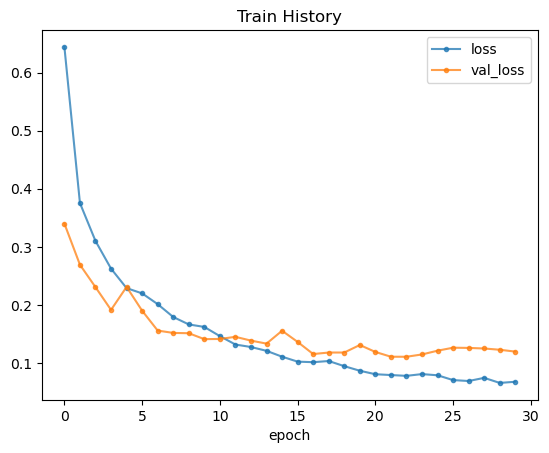

46/46 [==============================] - 0s 4ms/step - loss: 0.1002 - accuracy: 0.9624
8612
Epoch 1/30
371/371 [==============================] - 3s 9ms/step - loss: 0.5907 - accuracy: 0.7465 - val_loss: 0.3388 - val_accuracy: 0.8853
Epoch 2/30
371/371 [==============================] - 3s 8ms/step - loss: 0.3406 - accuracy: 0.8732 - val_loss: 0.2565 - val_accuracy: 0.9089
Epoch 3/30
371/371 [==============================] - 3s 8ms/step - loss: 0.2775 - accuracy: 0.8951 - val_loss: 0.2149 - val_accuracy: 0.9195
Epoch 4/30
371/371 [==============================] - 3s 8ms/step - loss: 0.2545 - accuracy: 0.9025 - val_loss: 0.2009 - val_accuracy: 0.9286
Epoch 5/30
371/371 [==============================] - 3s 8ms/step - loss: 0.2271 - accuracy: 0.9130 - val_loss: 0.1856 - val_accuracy: 0.9362
Epoch 6/30
371/371 [==============================] - 3s 8ms/step - loss: 0.2019 - accuracy: 0.9243 - val_loss: 0.1597 - val_accuracy: 0.9400
Epoch 7/30
371/371 [==============================] - 3s

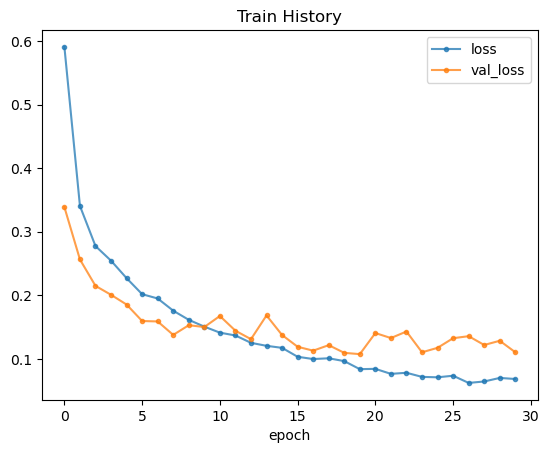

46/46 [==============================] - 0s 4ms/step - loss: 0.1077 - accuracy: 0.9542
7897
Epoch 1/30
371/371 [==============================] - 4s 9ms/step - loss: 0.5832 - accuracy: 0.7512 - val_loss: 0.3953 - val_accuracy: 0.8489
Epoch 2/30
371/371 [==============================] - 3s 9ms/step - loss: 0.3357 - accuracy: 0.8751 - val_loss: 0.2547 - val_accuracy: 0.9081
Epoch 3/30
371/371 [==============================] - 3s 9ms/step - loss: 0.2698 - accuracy: 0.8991 - val_loss: 0.2369 - val_accuracy: 0.9150
Epoch 4/30
371/371 [==============================] - 3s 9ms/step - loss: 0.2455 - accuracy: 0.9099 - val_loss: 0.1922 - val_accuracy: 0.9286
Epoch 5/30
371/371 [==============================] - 3s 9ms/step - loss: 0.2177 - accuracy: 0.9210 - val_loss: 0.1795 - val_accuracy: 0.9393
Epoch 6/30
371/371 [==============================] - 3s 9ms/step - loss: 0.2016 - accuracy: 0.9241 - val_loss: 0.1830 - val_accuracy: 0.9370
Epoch 7/30
371/371 [==============================] - 3s

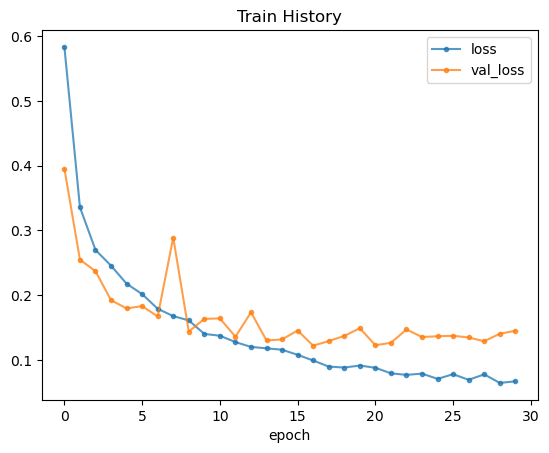

46/46 [==============================] - 0s 5ms/step - loss: 0.1355 - accuracy: 0.9590
7902
Epoch 1/30
371/371 [==============================] - 4s 10ms/step - loss: 0.6276 - accuracy: 0.7250 - val_loss: 0.3270 - val_accuracy: 0.8717
Epoch 2/30
371/371 [==============================] - 3s 9ms/step - loss: 0.3314 - accuracy: 0.8754 - val_loss: 0.2488 - val_accuracy: 0.9005
Epoch 3/30
371/371 [==============================] - 3s 9ms/step - loss: 0.2635 - accuracy: 0.8994 - val_loss: 0.2191 - val_accuracy: 0.9248
Epoch 4/30
371/371 [==============================] - 3s 9ms/step - loss: 0.2302 - accuracy: 0.9138 - val_loss: 0.2159 - val_accuracy: 0.9256
Epoch 5/30
371/371 [==============================] - 3s 9ms/step - loss: 0.2098 - accuracy: 0.9223 - val_loss: 0.1965 - val_accuracy: 0.9233
Epoch 6/30
371/371 [==============================] - 3s 9ms/step - loss: 0.1921 - accuracy: 0.9286 - val_loss: 0.2028 - val_accuracy: 0.9263
Epoch 7/30
371/371 [==============================] - 3

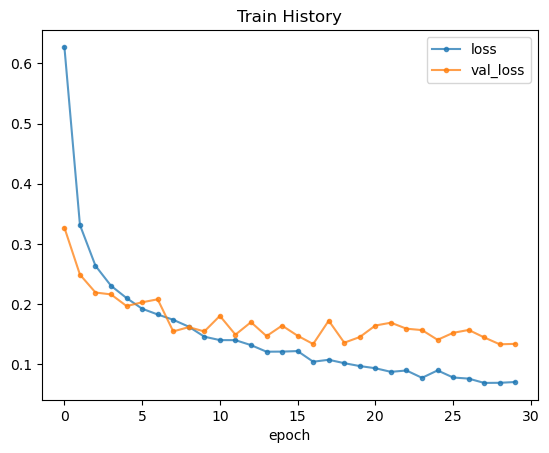

46/46 [==============================] - 0s 4ms/step - loss: 0.1336 - accuracy: 0.9576
-------------------------------
當前batch_size=64
7902
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.7102 - accuracy: 0.6830 - val_loss: 0.5504 - val_accuracy: 0.7897
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3703 - accuracy: 0.8599 - val_loss: 0.2611 - val_accuracy: 0.9028
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2990 - accuracy: 0.8905 - val_loss: 0.2387 - val_accuracy: 0.9112
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2773 - accuracy: 0.8954 - val_loss: 0.2570 - val_accuracy: 0.8975
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2615 - accuracy: 0.9023 - val_loss: 0.1838 - val_accuracy: 0.9279
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2271 - accuracy: 0.9161 - val_loss: 0.2187 - val_accuracy: 0.9188
Ep

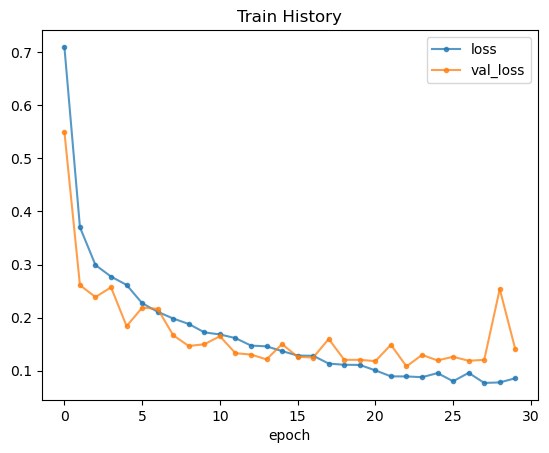

46/46 [==============================] - 0s 4ms/step - loss: 0.1134 - accuracy: 0.9617
8001
Epoch 1/30
186/186 [==============================] - 3s 15ms/step - loss: 0.8245 - accuracy: 0.6122 - val_loss: 0.5350 - val_accuracy: 0.7973
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.4666 - accuracy: 0.8162 - val_loss: 0.4002 - val_accuracy: 0.8383
Epoch 3/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3847 - accuracy: 0.8536 - val_loss: 0.3027 - val_accuracy: 0.8952
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3368 - accuracy: 0.8728 - val_loss: 0.2816 - val_accuracy: 0.8945
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3151 - accuracy: 0.8785 - val_loss: 0.2378 - val_accuracy: 0.9127
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2736 - accuracy: 0.9003 - val_loss: 0.2584 - val_accuracy: 0.9043
Epoch 7/30
186/186 [==============================

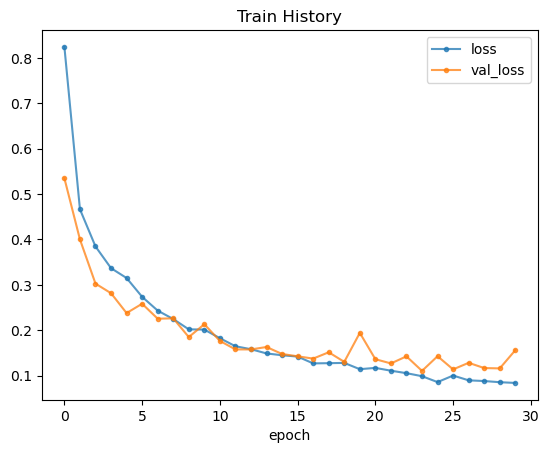

46/46 [==============================] - 0s 5ms/step - loss: 0.1417 - accuracy: 0.9487
8812
Epoch 1/30
186/186 [==============================] - 3s 16ms/step - loss: 0.7086 - accuracy: 0.6670 - val_loss: 0.4020 - val_accuracy: 0.8405
Epoch 2/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3638 - accuracy: 0.8639 - val_loss: 0.2759 - val_accuracy: 0.9043
Epoch 3/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2889 - accuracy: 0.8938 - val_loss: 0.2515 - val_accuracy: 0.9066
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2542 - accuracy: 0.9077 - val_loss: 0.2269 - val_accuracy: 0.9188
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2200 - accuracy: 0.9205 - val_loss: 0.1994 - val_accuracy: 0.9324
Epoch 6/30
186/186 [==============================] - 3s 15ms/step - loss: 0.2109 - accuracy: 0.9219 - val_loss: 0.1734 - val_accuracy: 0.9377
Epoch 7/30
186/186 [==============================

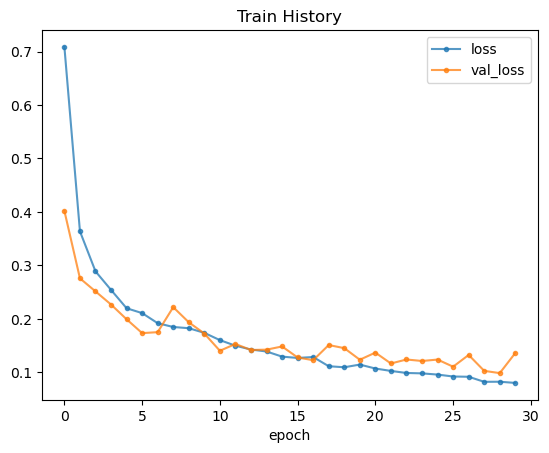

46/46 [==============================] - 0s 4ms/step - loss: 0.1352 - accuracy: 0.9522
8001
Epoch 1/30
186/186 [==============================] - 3s 16ms/step - loss: 0.8102 - accuracy: 0.6106 - val_loss: 0.4806 - val_accuracy: 0.8094
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.4324 - accuracy: 0.8275 - val_loss: 0.3135 - val_accuracy: 0.8778
Epoch 3/30
186/186 [==============================] - 3s 15ms/step - loss: 0.3276 - accuracy: 0.8736 - val_loss: 0.2590 - val_accuracy: 0.9066
Epoch 4/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2743 - accuracy: 0.8951 - val_loss: 0.2163 - val_accuracy: 0.9218
Epoch 5/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2349 - accuracy: 0.9145 - val_loss: 0.2304 - val_accuracy: 0.9134
Epoch 6/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2103 - accuracy: 0.9218 - val_loss: 0.2004 - val_accuracy: 0.9195
Epoch 7/30
186/186 [==============================

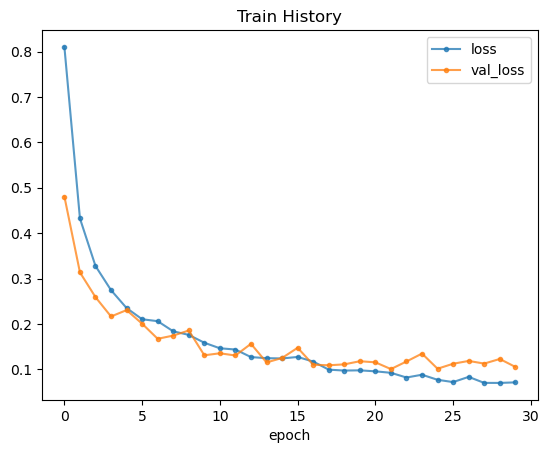

46/46 [==============================] - 0s 4ms/step - loss: 0.1034 - accuracy: 0.9679
8119
Epoch 1/30
186/186 [==============================] - 3s 14ms/step - loss: 0.6880 - accuracy: 0.6833 - val_loss: 0.4588 - val_accuracy: 0.8216
Epoch 2/30
186/186 [==============================] - 3s 14ms/step - loss: 0.3559 - accuracy: 0.8623 - val_loss: 0.3066 - val_accuracy: 0.8861
Epoch 3/30
186/186 [==============================] - 2s 13ms/step - loss: 0.2848 - accuracy: 0.8938 - val_loss: 0.2194 - val_accuracy: 0.9188
Epoch 4/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2384 - accuracy: 0.9113 - val_loss: 0.1982 - val_accuracy: 0.9195
Epoch 5/30
186/186 [==============================] - 3s 14ms/step - loss: 0.2177 - accuracy: 0.9181 - val_loss: 0.1920 - val_accuracy: 0.9241
Epoch 6/30
186/186 [==============================] - 3s 14ms/step - loss: 0.1948 - accuracy: 0.9279 - val_loss: 0.1816 - val_accuracy: 0.9279
Epoch 7/30
186/186 [==============================

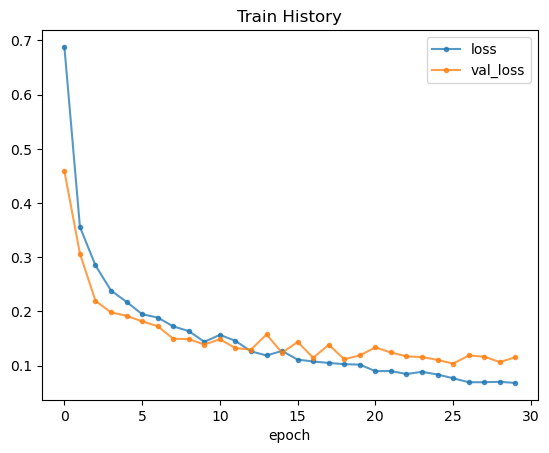

46/46 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.9686
-------------------------------
當前batch_size=128
8026
Epoch 1/30
93/93 [==============================] - 3s 27ms/step - loss: 0.9501 - accuracy: 0.5186 - val_loss: 0.6239 - val_accuracy: 0.7236
Epoch 2/30
93/93 [==============================] - 2s 25ms/step - loss: 0.5205 - accuracy: 0.7954 - val_loss: 0.4186 - val_accuracy: 0.8443
Epoch 3/30
93/93 [==============================] - 2s 24ms/step - loss: 0.4026 - accuracy: 0.8466 - val_loss: 0.3168 - val_accuracy: 0.8831
Epoch 4/30
93/93 [==============================] - 2s 25ms/step - loss: 0.3296 - accuracy: 0.8765 - val_loss: 0.2451 - val_accuracy: 0.9081
Epoch 5/30
93/93 [==============================] - 2s 23ms/step - loss: 0.2938 - accuracy: 0.8893 - val_loss: 0.2272 - val_accuracy: 0.9150
Epoch 6/30
93/93 [==============================] - 2s 23ms/step - loss: 0.2705 - accuracy: 0.9008 - val_loss: 0.2031 - val_accuracy: 0.9263
Epoch 7/30
93

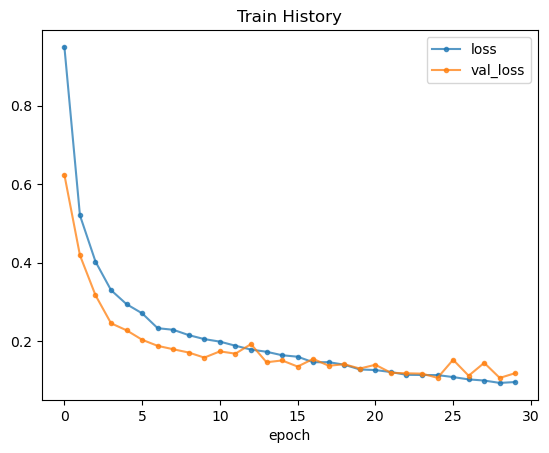

46/46 [==============================] - 0s 4ms/step - loss: 0.1139 - accuracy: 0.9624
7721
Epoch 1/30
93/93 [==============================] - 3s 26ms/step - loss: 0.8353 - accuracy: 0.6032 - val_loss: 0.5500 - val_accuracy: 0.7813
Epoch 2/30
93/93 [==============================] - 2s 24ms/step - loss: 0.4640 - accuracy: 0.8189 - val_loss: 0.3544 - val_accuracy: 0.8679
Epoch 3/30
93/93 [==============================] - 2s 24ms/step - loss: 0.3938 - accuracy: 0.8521 - val_loss: 0.3268 - val_accuracy: 0.8861
Epoch 4/30
93/93 [==============================] - 2s 24ms/step - loss: 0.3353 - accuracy: 0.8749 - val_loss: 0.2793 - val_accuracy: 0.9021
Epoch 5/30
93/93 [==============================] - 2s 23ms/step - loss: 0.2854 - accuracy: 0.8949 - val_loss: 0.2562 - val_accuracy: 0.9150
Epoch 6/30
93/93 [==============================] - 2s 23ms/step - loss: 0.2622 - accuracy: 0.9052 - val_loss: 0.2168 - val_accuracy: 0.9188
Epoch 7/30
93/93 [==============================] - 2s 23ms/st

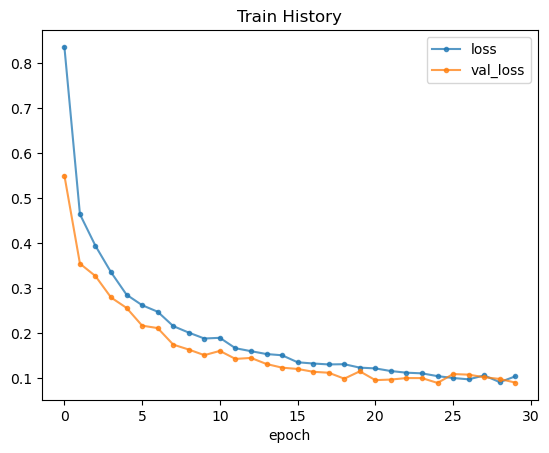

46/46 [==============================] - 0s 4ms/step - loss: 0.0971 - accuracy: 0.9645
8817
Epoch 1/30
93/93 [==============================] - 3s 26ms/step - loss: 0.8584 - accuracy: 0.5835 - val_loss: 0.4395 - val_accuracy: 0.8504
Epoch 2/30
93/93 [==============================] - 2s 25ms/step - loss: 0.4100 - accuracy: 0.8441 - val_loss: 0.2768 - val_accuracy: 0.8929
Epoch 3/30
93/93 [==============================] - 2s 24ms/step - loss: 0.3384 - accuracy: 0.8756 - val_loss: 0.2496 - val_accuracy: 0.9096
Epoch 4/30
93/93 [==============================] - 2s 25ms/step - loss: 0.3011 - accuracy: 0.8881 - val_loss: 0.2317 - val_accuracy: 0.9218
Epoch 5/30
93/93 [==============================] - 2s 24ms/step - loss: 0.2719 - accuracy: 0.8994 - val_loss: 0.2139 - val_accuracy: 0.9226
Epoch 6/30
93/93 [==============================] - 2s 24ms/step - loss: 0.2543 - accuracy: 0.9095 - val_loss: 0.2114 - val_accuracy: 0.9294
Epoch 7/30
93/93 [==============================] - 2s 24ms/st

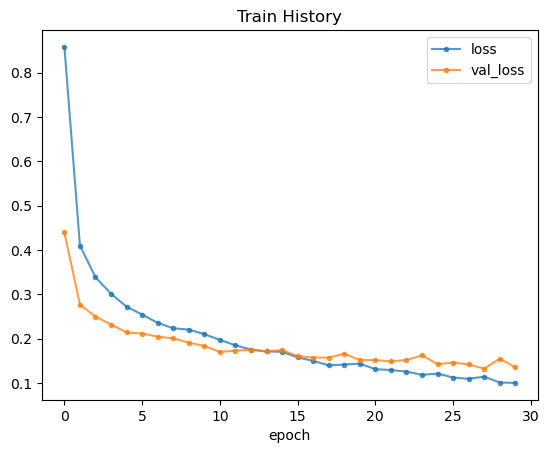

46/46 [==============================] - 0s 5ms/step - loss: 0.1216 - accuracy: 0.9508
8128
Epoch 1/30
93/93 [==============================] - 3s 25ms/step - loss: 0.9077 - accuracy: 0.5421 - val_loss: 0.6330 - val_accuracy: 0.7623
Epoch 2/30
93/93 [==============================] - 2s 24ms/step - loss: 0.5687 - accuracy: 0.7734 - val_loss: 0.4726 - val_accuracy: 0.8170
Epoch 3/30
93/93 [==============================] - 2s 23ms/step - loss: 0.4644 - accuracy: 0.8199 - val_loss: 0.4055 - val_accuracy: 0.8466
Epoch 4/30
93/93 [==============================] - 2s 24ms/step - loss: 0.3894 - accuracy: 0.8522 - val_loss: 0.3122 - val_accuracy: 0.8884
Epoch 5/30
93/93 [==============================] - 2s 23ms/step - loss: 0.3391 - accuracy: 0.8715 - val_loss: 0.2826 - val_accuracy: 0.8945
Epoch 6/30
93/93 [==============================] - 2s 22ms/step - loss: 0.3051 - accuracy: 0.8870 - val_loss: 0.2507 - val_accuracy: 0.9089
Epoch 7/30
93/93 [==============================] - 2s 22ms/st

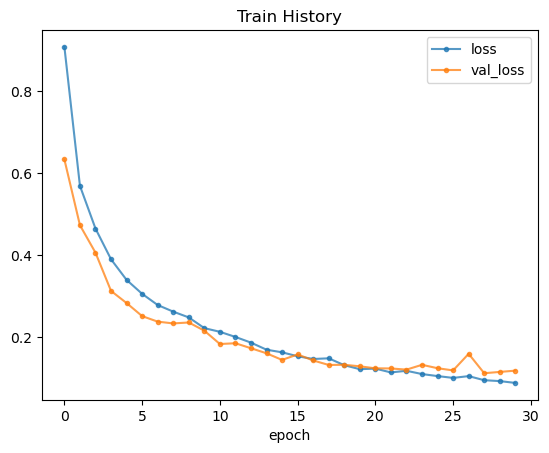

46/46 [==============================] - 0s 5ms/step - loss: 0.1119 - accuracy: 0.9651
7721
Epoch 1/30
93/93 [==============================] - 3s 28ms/step - loss: 0.8808 - accuracy: 0.5843 - val_loss: 0.6139 - val_accuracy: 0.7472
Epoch 2/30
93/93 [==============================] - 2s 23ms/step - loss: 0.5764 - accuracy: 0.7671 - val_loss: 0.4626 - val_accuracy: 0.8162
Epoch 3/30
93/93 [==============================] - 2s 23ms/step - loss: 0.4493 - accuracy: 0.8278 - val_loss: 0.3935 - val_accuracy: 0.8443
Epoch 4/30
93/93 [==============================] - 2s 24ms/step - loss: 0.3877 - accuracy: 0.8501 - val_loss: 0.3260 - val_accuracy: 0.8717
Epoch 5/30
93/93 [==============================] - 2s 23ms/step - loss: 0.3283 - accuracy: 0.8800 - val_loss: 0.2718 - val_accuracy: 0.9005
Epoch 6/30
93/93 [==============================] - 2s 23ms/step - loss: 0.3031 - accuracy: 0.8853 - val_loss: 0.2472 - val_accuracy: 0.9074
Epoch 7/30
93/93 [==============================] - 2s 24ms/st

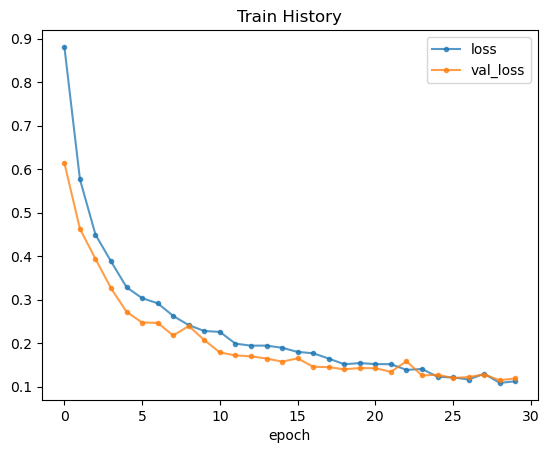

46/46 [==============================] - 0s 4ms/step - loss: 0.1138 - accuracy: 0.9624
-------------------------------
當前batch_size=256
8226
Epoch 1/30
47/47 [==============================] - 3s 46ms/step - loss: 1.0697 - accuracy: 0.3961 - val_loss: 0.9729 - val_accuracy: 0.5019
Epoch 2/30
47/47 [==============================] - 2s 42ms/step - loss: 0.8804 - accuracy: 0.5763 - val_loss: 0.7274 - val_accuracy: 0.6864
Epoch 3/30
47/47 [==============================] - 2s 43ms/step - loss: 0.6367 - accuracy: 0.7378 - val_loss: 0.5125 - val_accuracy: 0.7927
Epoch 4/30
47/47 [==============================] - 2s 42ms/step - loss: 0.4960 - accuracy: 0.8086 - val_loss: 0.4341 - val_accuracy: 0.8345
Epoch 5/30
47/47 [==============================] - 2s 42ms/step - loss: 0.4415 - accuracy: 0.8324 - val_loss: 0.4012 - val_accuracy: 0.8504
Epoch 6/30
47/47 [==============================] - 2s 42ms/step - loss: 0.4073 - accuracy: 0.8459 - val_loss: 0.4072 - val_accuracy: 0.8459
Epoch 7/30
47

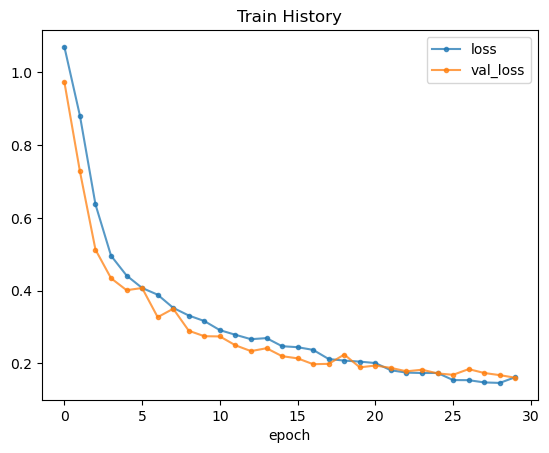

46/46 [==============================] - 0s 4ms/step - loss: 0.1398 - accuracy: 0.9453
7840
Epoch 1/30
47/47 [==============================] - 2s 44ms/step - loss: 0.9420 - accuracy: 0.5328 - val_loss: 0.6441 - val_accuracy: 0.7365
Epoch 2/30
47/47 [==============================] - 2s 40ms/step - loss: 0.6184 - accuracy: 0.7476 - val_loss: 0.5250 - val_accuracy: 0.7995
Epoch 3/30
47/47 [==============================] - 2s 40ms/step - loss: 0.4829 - accuracy: 0.8100 - val_loss: 0.4196 - val_accuracy: 0.8352
Epoch 4/30
47/47 [==============================] - 2s 41ms/step - loss: 0.4211 - accuracy: 0.8361 - val_loss: 0.3901 - val_accuracy: 0.8527
Epoch 5/30
47/47 [==============================] - 2s 40ms/step - loss: 0.3861 - accuracy: 0.8510 - val_loss: 0.3608 - val_accuracy: 0.8694
Epoch 6/30
47/47 [==============================] - 2s 41ms/step - loss: 0.3415 - accuracy: 0.8712 - val_loss: 0.3303 - val_accuracy: 0.8793
Epoch 7/30
47/47 [==============================] - 2s 41ms/st

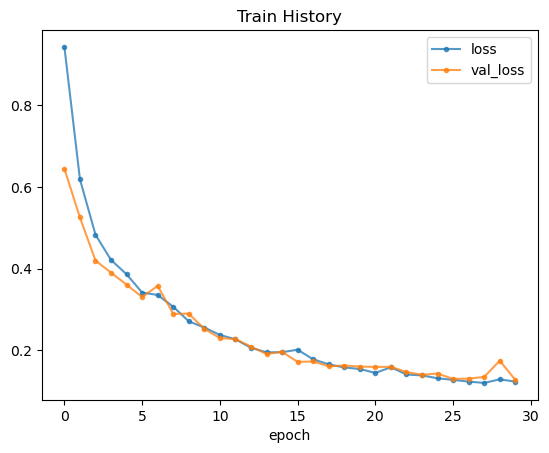

46/46 [==============================] - 0s 4ms/step - loss: 0.1142 - accuracy: 0.9556
4859
Epoch 1/30
47/47 [==============================] - 2s 44ms/step - loss: 0.9849 - accuracy: 0.5125 - val_loss: 0.7311 - val_accuracy: 0.6811
Epoch 2/30
47/47 [==============================] - 2s 40ms/step - loss: 0.6359 - accuracy: 0.7429 - val_loss: 0.5146 - val_accuracy: 0.7851
Epoch 3/30
47/47 [==============================] - 2s 40ms/step - loss: 0.4704 - accuracy: 0.8187 - val_loss: 0.3711 - val_accuracy: 0.8557
Epoch 4/30
47/47 [==============================] - 2s 41ms/step - loss: 0.3862 - accuracy: 0.8537 - val_loss: 0.3596 - val_accuracy: 0.8618
Epoch 5/30
47/47 [==============================] - 2s 41ms/step - loss: 0.3481 - accuracy: 0.8692 - val_loss: 0.2943 - val_accuracy: 0.8952
Epoch 6/30
47/47 [==============================] - 2s 42ms/step - loss: 0.3109 - accuracy: 0.8831 - val_loss: 0.2597 - val_accuracy: 0.9066
Epoch 7/30
47/47 [==============================] - 2s 42ms/st

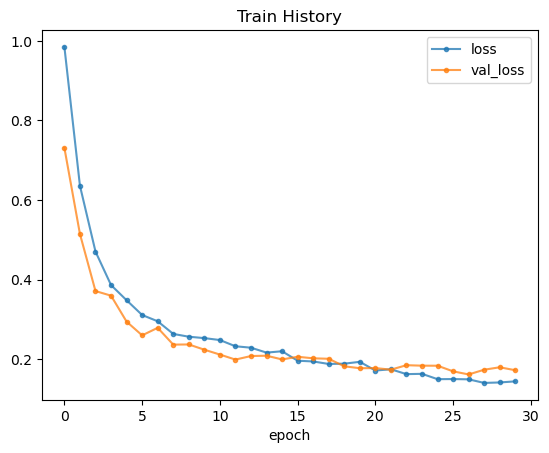

46/46 [==============================] - 0s 4ms/step - loss: 0.1463 - accuracy: 0.9392
7841
Epoch 1/30
47/47 [==============================] - 2s 45ms/step - loss: 0.8920 - accuracy: 0.5578 - val_loss: 0.6106 - val_accuracy: 0.7684
Epoch 2/30
47/47 [==============================] - 2s 41ms/step - loss: 0.5648 - accuracy: 0.7776 - val_loss: 0.4825 - val_accuracy: 0.8200
Epoch 3/30
47/47 [==============================] - 2s 42ms/step - loss: 0.4492 - accuracy: 0.8266 - val_loss: 0.3730 - val_accuracy: 0.8519
Epoch 4/30
47/47 [==============================] - 2s 41ms/step - loss: 0.3873 - accuracy: 0.8471 - val_loss: 0.3379 - val_accuracy: 0.8671
Epoch 5/30
47/47 [==============================] - 2s 42ms/step - loss: 0.3471 - accuracy: 0.8648 - val_loss: 0.3306 - val_accuracy: 0.8702
Epoch 6/30
47/47 [==============================] - 2s 41ms/step - loss: 0.3224 - accuracy: 0.8761 - val_loss: 0.2790 - val_accuracy: 0.8929
Epoch 7/30
47/47 [==============================] - 2s 42ms/st

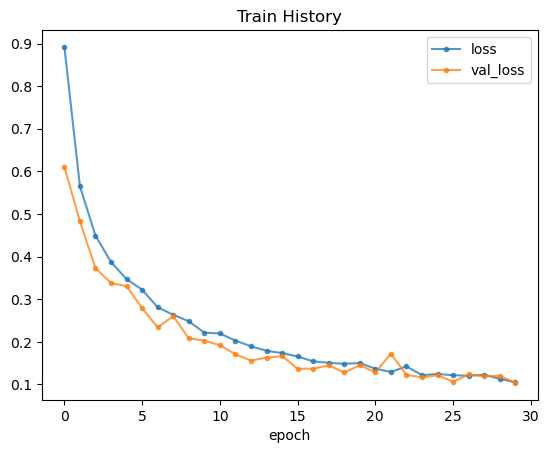

46/46 [==============================] - 0s 5ms/step - loss: 0.1048 - accuracy: 0.9658
8252
Epoch 1/30
47/47 [==============================] - 3s 47ms/step - loss: 0.9174 - accuracy: 0.5639 - val_loss: 0.6474 - val_accuracy: 0.7350
Epoch 2/30
47/47 [==============================] - 2s 45ms/step - loss: 0.5986 - accuracy: 0.7593 - val_loss: 0.4559 - val_accuracy: 0.8170
Epoch 3/30
47/47 [==============================] - 2s 45ms/step - loss: 0.4359 - accuracy: 0.8338 - val_loss: 0.3276 - val_accuracy: 0.8823
Epoch 4/30
47/47 [==============================] - 2s 42ms/step - loss: 0.3350 - accuracy: 0.8786 - val_loss: 0.2579 - val_accuracy: 0.9134
Epoch 5/30
47/47 [==============================] - 2s 44ms/step - loss: 0.2926 - accuracy: 0.8933 - val_loss: 0.2309 - val_accuracy: 0.9188
Epoch 6/30
47/47 [==============================] - 2s 44ms/step - loss: 0.2761 - accuracy: 0.8981 - val_loss: 0.2199 - val_accuracy: 0.9263
Epoch 7/30
47/47 [==============================] - 2s 45ms/st

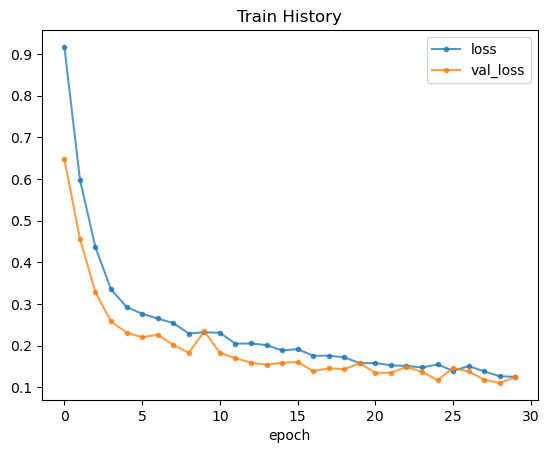

46/46 [==============================] - 0s 4ms/step - loss: 0.1318 - accuracy: 0.9542
[[0.12503032386302948, 0.9617224931716919], [0.10023701190948486, 0.9624060392379761], [0.10767553001642227, 0.9542036652565002], [0.13553673028945923, 0.9589883685112], [0.13356947898864746, 0.9576213359832764], [0.11344199627637863, 0.9617224931716919], [0.14167794585227966, 0.9487354755401611], [0.13520461320877075, 0.9521530866622925], [0.10341492295265198, 0.9678742289543152], [0.08897212147712708, 0.9685577750205994], [0.11386967450380325, 0.9624060392379761], [0.09710395336151123, 0.9644566178321838], [0.12162207812070847, 0.9507860541343689], [0.11189129203557968, 0.9651401042938232], [0.11384337395429611, 0.9624060392379761], [0.13981817662715912, 0.9453178644180298], [0.11420417577028275, 0.9555707573890686], [0.14634771645069122, 0.9391660690307617], [0.10478904843330383, 0.9658236503601074], [0.13177943229675293, 0.9542036652565002]]


In [8]:
score=[]
for size in [32,64,128,256]:
    print("-------------------------------\n當前batch_size=%d"%size)
    for i in range(5):
        np.random.seed(i)
        reset_keras()
        model_CNN=Sequential()
        model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
        model_CNN.add(MaxPooling2D(pool_size=(2,2)))
        model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
        model_CNN.add(MaxPooling2D(pool_size=(2,2)))
        model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
        model_CNN.add(MaxPooling2D(pool_size=(2,2)))
        model_CNN.add(Dropout(0.45))
        model_CNN.add(Flatten())
        model_CNN.add(Dense(units=32, activation='relu'))
        model_CNN.add(Dense(units=16, activation='relu'))
        model_CNN.add(Dense(units=3, activation='softmax'))
        model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        if i == 1:
            plot_model(model_CNN,show_shapes=True)
        train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=30,batch_size=size,verbose=1)
        plt.title("Train History")
        plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
        plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
        plt.xlabel("epoch")
        plt.legend(["loss","val_loss"])
        plt.show()
        score.append(model_CNN.evaluate(test_feature,test_label))
print(score)

## 實驗5-最終驗證

43
Epoch 1/30
93/93 [==============================] - 7s 26ms/step - loss: 0.9365 - accuracy: 0.5361 - val_loss: 0.6400 - val_accuracy: 0.7122
Epoch 2/30
93/93 [==============================] - 2s 22ms/step - loss: 0.5299 - accuracy: 0.7930 - val_loss: 0.3925 - val_accuracy: 0.8489
Epoch 3/30
93/93 [==============================] - 2s 22ms/step - loss: 0.4048 - accuracy: 0.8451 - val_loss: 0.3587 - val_accuracy: 0.8694
Epoch 4/30
93/93 [==============================] - 2s 22ms/step - loss: 0.3378 - accuracy: 0.8713 - val_loss: 0.2575 - val_accuracy: 0.8998
Epoch 5/30
93/93 [==============================] - 2s 22ms/step - loss: 0.2908 - accuracy: 0.8908 - val_loss: 0.2591 - val_accuracy: 0.8983
Epoch 6/30
93/93 [==============================] - 2s 22ms/step - loss: 0.2737 - accuracy: 0.8983 - val_loss: 0.2321 - val_accuracy: 0.9051
Epoch 7/30
93/93 [==============================] - 2s 22ms/step - loss: 0.2531 - accuracy: 0.9031 - val_loss: 0.2374 - val_accuracy: 0.9051
Epoch 8/30

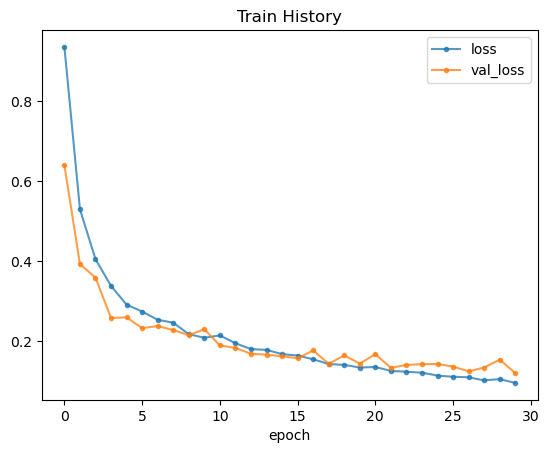

[0.12065792828798294, 0.9555707573890686]


In [5]:
np.random.seed(1)
reset_keras()
model_CNN=Sequential()
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',input_shape=(128,128,3),activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Conv2D(filters=5,kernel_size=(5,5),padding='same',activation='relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))
model_CNN.add(Dropout(0.45))
model_CNN.add(Flatten())
model_CNN.add(Dense(units=32, activation='relu'))
model_CNN.add(Dense(units=16, activation='relu'))
model_CNN.add(Dense(units=3, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
train_history=model_CNN.fit(train_feature,train_label,validation_split=0.1,epochs=30,batch_size=128,verbose=1)
score=model_CNN.evaluate(test_feature,test_label)
plt.title("Train History")
plt.plot(train_history.history['loss'],marker='.',alpha=0.75)
plt.plot(train_history.history['val_loss'],marker='.',alpha=0.75)
plt.xlabel("epoch")
plt.legend(["loss","val_loss"])
plt.show()
print(score)

In [6]:
val_cat_files=glob.glob("./val/cat/*.jpg")
val_dog_files=glob.glob("./val/dog/*.jpg")
val_wildlife_files=glob.glob("./val/wild/*.jpg")
val_feature,val_label=data_preprocessing(val_cat_files,val_dog_files,val_wildlife_files)

In [7]:
reset_keras()
val_pre=model_CNN.predict(val_feature)
val_score=model_CNN.evaluate(val_feature,val_label)
print(val_score)

5216
47/47 [==============================] - 0s 4ms/step - loss: 0.1186 - accuracy: 0.9613
[0.11856146901845932, 0.9613333344459534]


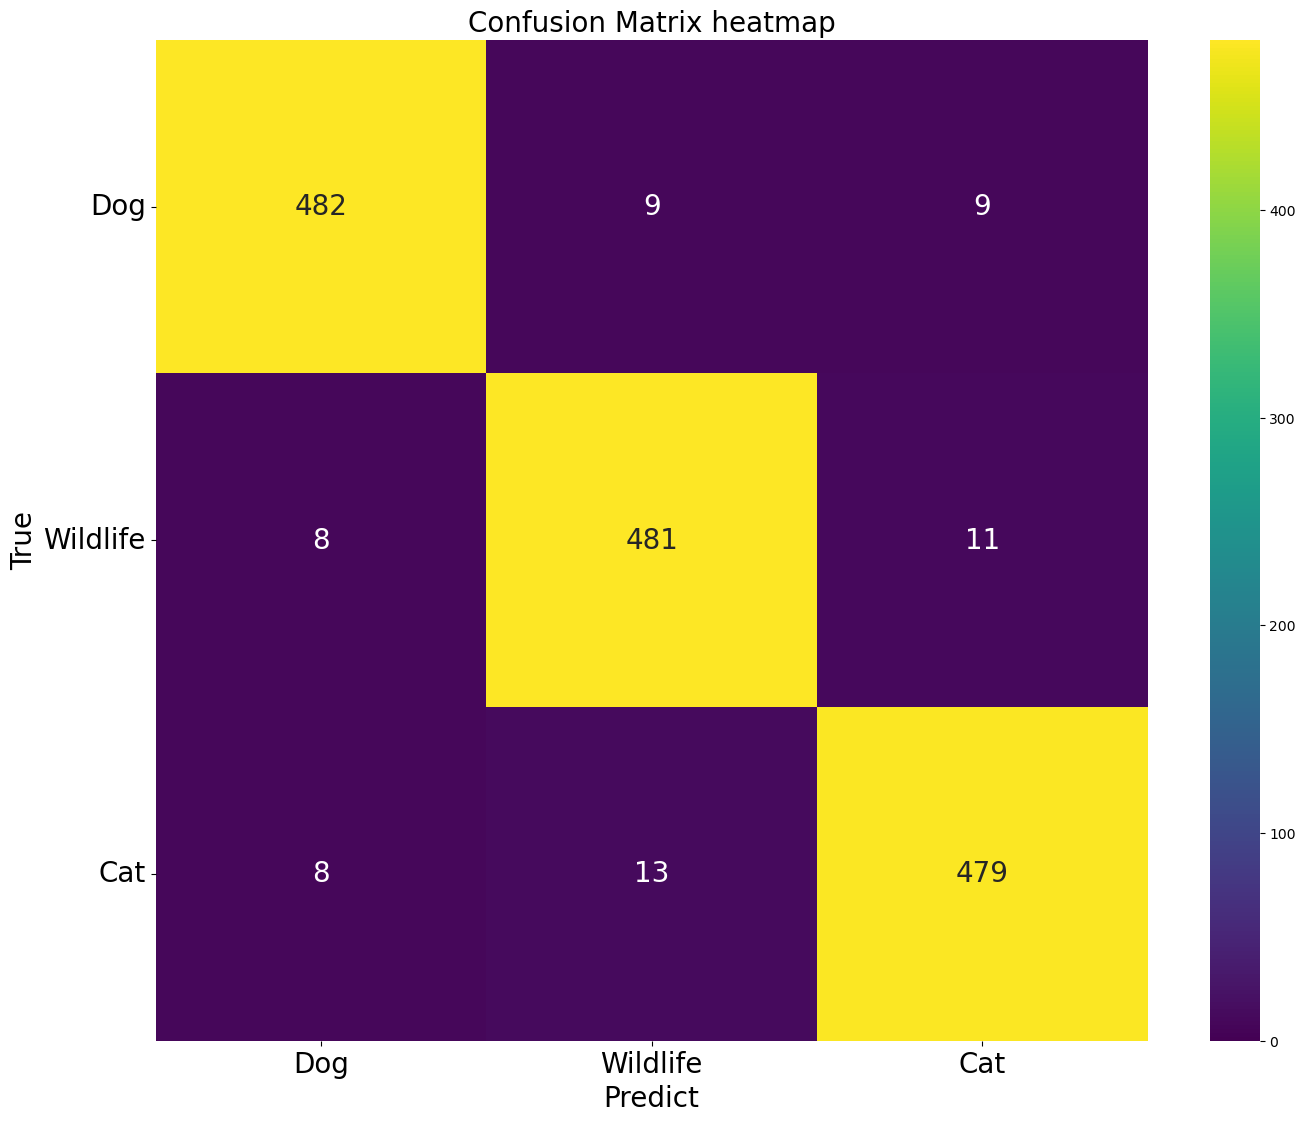

In [14]:
heatmap_label={"Cat","Dog","Wildlife"}
from sklearn.metrics import confusion_matrix
import seaborn as sebrn
import matplotlib.pyplot as atlas
cm=confusion_matrix(np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1))
plt.figure(figsize=(16, 13))
heatmap=sebrn.heatmap(cm,fmt='d',vmin=0,annot=True,cmap='viridis',annot_kws={"size": 20, "verticalalignment": "center", "horizontalalignment": "center"})
plt.ylabel("True",fontsize=20)
heatmap.set_xticklabels(heatmap_label, fontsize=20)
plt.xlabel("Predict",fontsize=20)
heatmap.set_yticklabels(heatmap_label, rotation=0, fontsize=20)
plt.title("Confusion Matrix heatmap",fontsize=20)
plt.show()

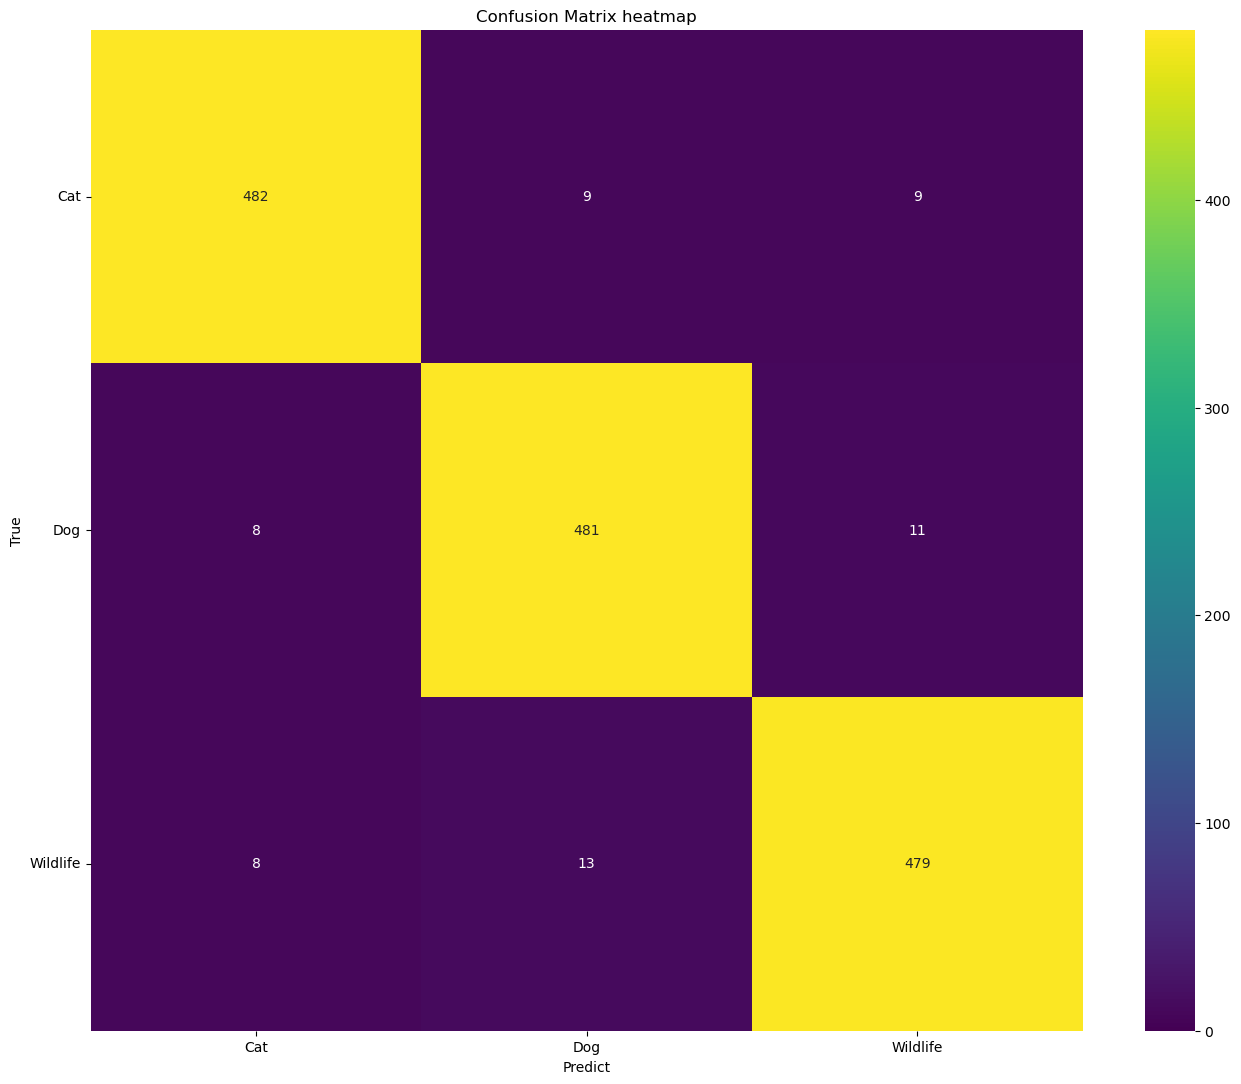

In [8]:
heatmap_label={"Cat","Dog","Wildlife"}
from sklearn.metrics import confusion_matrix
import seaborn as sebrn
import matplotlib.pyplot as atlas
cm=confusion_matrix(np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1))
plt.figure(figsize=(16, 13))
heatmap=sebrn.heatmap(cm,fmt='d',vmin=0,annot=True,cmap='viridis',annot_kws={"size": 10, "verticalalignment": "center", "horizontalalignment": "center"})
plt.ylabel("True")
heatmap.set_xticklabels(heatmap_label)
plt.xlabel("Predict")
heatmap.set_yticklabels(heatmap_label, rotation=0)
plt.title("Confusion Matrix heatmap")
plt.show()

In [19]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1)))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       500
           1       0.96      0.96      0.96       500
           2       0.95      0.96      0.96       500

    accuracy                           0.96      1500
   macro avg       0.96      0.96      0.96      1500
weighted avg       0.96      0.96      0.96      1500



In [23]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print("%.4f"%f1_score(np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1),average="weighted"))
print("%.4f"%precision_score(np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1),average="weighted"))
print("%.4f"%recall_score(np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1),average="weighted"))

0.9640
0.9640
0.9640


In [ ]:
for i in range(0,14):
    show_images_labels_predictions(val_feature,np.argmax(val_label,axis=1),np.argmax(val_pre,axis=1),(i*25),(i*25+25))